<a href="https://colab.research.google.com/github/sbooeshaghi/mx/blob/master/test/gmm_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet -U scikit-learn kb_python anndata

     |████████████████████████████████| 23.1 MB 5.0 kB/s 
     |████████████████████████████████| 7.4 MB 39.7 MB/s 
     |████████████████████████████████| 127 kB 51.9 MB/s 
     |████████████████████████████████| 41 kB 111 kB/s 
     |████████████████████████████████| 51.7 MB 16 kB/s 
     |████████████████████████████████| 23.9 MB 15 kB/s 
     |████████████████████████████████| 2.0 MB 50.6 MB/s 
     |████████████████████████████████| 48 kB 5.1 MB/s 
     |████████████████████████████████| 3.3 MB 49.0 MB/s 
     |████████████████████████████████| 12.3 MB 44.9 MB/s 
     |████████████████████████████████| 26.3 MB 93 kB/s 
     |████████████████████████████████| 80 kB 8.0 MB/s 
     |████████████████████████████████| 1.1 MB 52.4 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 


In [2]:
!git clone https://github.com/sbooeshaghi/sim.git

Cloning into 'sim'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 47 (delta 10), reused 46 (delta 9), pack-reused 0
Unpacking objects: 100% (47/47), done.


In [3]:
!gunzip -r sim/*

In [4]:
import anndata
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kb_python.utils import import_matrix_as_anndata

from scipy.io import mmread, mmwrite
from scipy.spatial.distance import cdist
from collections import defaultdict

from sklearn.metrics import adjusted_rand_score, rand_score
from sklearn.datasets import make_blobs
from sklearn.preprocessing import normalize
from sklearn.mixture import GaussianMixture as StandardGaussianMixture
from sklearn.cluster import KMeans as KMeans
from sklearn.mixture._gaussian_mixture import _estimate_gaussian_parameters as est_gaus_params 
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.neighbors import KDTree

def nd(arr):
    return np.asarray(arr).reshape(-1)

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [5]:
# preprocess splatter file into markers file
def write_markers(fname, markers):
    with open(fname, "w") as f:
        for k, v in markers.items():
            f.write(f"{k}\t")
            n = len(v)
            for idx, i in enumerate(v):
                f.write(f"{i}")
                if idx < n - 1:
                    f.write(",")
            f.write("\n")

In [6]:
ds = "0_defaultparams"
genes_metadata_fname = f"sim/{ds}/genes_metadata.txt"
matrix_fname = f"sim/{ds}/matrix.mtx"
genes_fname = f"sim/{ds}/genes.txt"
labels_fname = f"sim/{ds}/labels.txt"

In [7]:
n_sample = 10

df = pd.read_csv(genes_metadata_fname)
# splatter get marker genes
markers = defaultdict(list)
for i in range(1,11):
    # genes = df[df[f"DEFacGroup{i}"] > 1.5].sample(n_sample, random_state=0)["Gene"].values
    genes = df[df[f"DEFacGroup{i}"] > 1.5]["Gene"].values
    for j in genes:
        markers[f"group{i}"].append(j)
write_markers("markers.txt", markers)

In [8]:
def write_dict(fname, d):
  inv_d = {v:k for k,v in d.items()}
  with open(fname, "w") as f:
    for idx in range(len(d)):
      f.write(f'{inv_d[idx]}\n')

In [9]:
def read_markers(fname, markers_ec=defaultdict(list), celltype=defaultdict(), marker_genes=defaultdict()):
  with open(fname, "r") as f:
    for idx, line in enumerate(f.readlines()):
      ct, genes = line.strip().split('\t')
      celltype[ct] = idx
      
      # two things
      # 1. make marker_genes list
      # 2. make markers_ec
      for g in genes.split(','):
        gidx = len(marker_genes)
        
        # check if the gene has been added already
        if g in marker_genes.keys(): # gene repeated
          gidx = marker_genes[g]
        else:
          marker_genes[g] = gidx
        
        # for the cell type index, add the marker gene index 
        markers_ec[celltype[ct]].append(marker_genes[g])
      
      # sort the marker genes
      markers_ec[celltype[ct]] = sorted(markers_ec[celltype[ct]])

In [10]:
markers_ec=defaultdict(list)
celltypes=defaultdict()
marker_genes=defaultdict()
read_markers("markers.txt", markers_ec, celltypes, marker_genes)

In [11]:
write_markers("markers.ec", markers_ec)
write_dict("types.txt", celltypes)
write_dict("marker_genes.txt", marker_genes)

In [12]:
# # simple way to verify that the markers are consistent
# mg_inv = {v:k for k,v in marker_genes.items()}
# i = 1
# for idx in markers_ec[i]:
#   check = mg_inv[idx] in markers[f"group{i+1}"]
#   if not check:
#     print("bad")

In [13]:
# adata = anndata.read_h5ad("adata.h5ad")
# mmwrite("matrix.mtx", adata.X.astype(int))
# adata.obs.to_csv("barcodes.txt", header=False, index=True, columns=[])
# adata.var.to_csv("genes.txt", header=False, index=True, columns=[])
# adata.obs.to_csv("labels.txt", header=False, index=True, columns=["cell_type"], sep="\t")

# Select the marker genes from the matrix and save the matrix

In [14]:
mtx = mmread(matrix_fname).tocsr()

In [15]:
genes = defaultdict()

with open(genes_fname) as f:
  for idx, line in enumerate(f.readlines()):
    gene = line.strip()
    genes[gene] = idx

In [16]:
mg_inv = {v:k for k,v in marker_genes.items()}

sel = []
for idx in range(len(mg_inv)):
  # this maps the marker gene name index to the gene index
  # in order of the marker_genes file
  sel.append(genes[mg_inv[idx]])

In [17]:
len(sel)

153

In [18]:
mmwrite("matrix_select.mtx", mtx[:,sel])

In [19]:
if np.array([1,1]) is None:
  print("helo")

In [20]:
list(markers_ec.keys())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [22]:
def mec2b(markers_ec):
  n_clusters = len(list(markers_ec.keys()))
  n_features = np.unique(sum(list(markers_ec.values()), [])).shape[0]
  B = np.zeros((n_clusters, n_features))
  for k,v in markers_ec.items():
    B[k][v] = 1
  return B

In [23]:
B = mec2b(markers_ec)

# Test out the GMM

In [24]:
#@title sklearn/mixture/_base.py

"""Base class for mixture models."""

# sklearn/mixture/_base.py

# Author: Wei Xue <xuewei4d@gmail.com>
# Modified by Thierry Guillemot <thierry.guillemot.work@gmail.com>
# License: BSD 3 clause

import warnings
from abc import ABCMeta, abstractmethod
from time import time

import numpy as np
from scipy.special import logsumexp

from sklearn import cluster
from sklearn.base import BaseEstimator
from sklearn.base import DensityMixin
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import check_random_state
from sklearn.utils.validation import check_is_fitted


def _check_shape(param, param_shape, name):
    """Validate the shape of the input parameter 'param'.

    Parameters
    ----------
    param : array

    param_shape : tuple

    name : str
    """
    param = np.array(param)
    if param.shape != param_shape:
        raise ValueError(
            "The parameter '%s' should have the shape of %s, but got %s" %
            (name, param_shape, param.shape))


class BaseMixture(DensityMixin, BaseEstimator, metaclass=ABCMeta):
    """Base class for mixture models.

    This abstract class specifies an interface for all mixture classes and
    provides basic common methods for mixture models.
    """
    def __init__(
        self,
        n_components,
        tol,
        reg_covar,
        max_iter,
        n_init,
        init_params,
        random_state,
        warm_start,
        verbose,
        verbose_interval,
    ):
        self.n_components = n_components
        self.tol = tol
        self.reg_covar = reg_covar
        self.max_iter = max_iter
        self.n_init = n_init
        self.init_params = init_params
        self.random_state = random_state
        self.warm_start = warm_start
        self.verbose = verbose
        self.verbose_interval = verbose_interval

    def _check_initial_parameters(self, X):
        """Check values of the basic parameters.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
        """
        if self.n_components < 1:
            raise ValueError("Invalid value for 'n_components': %d "
                             "Estimation requires at least one component" %
                             self.n_components)

        if self.tol < 0.0:
            raise ValueError("Invalid value for 'tol': %.5f "
                             "Tolerance used by the EM must be non-negative" %
                             self.tol)

        if self.n_init < 1:
            raise ValueError(
                "Invalid value for 'n_init': %d Estimation requires at least one run"
                % self.n_init)

        if self.max_iter < 1:
            raise ValueError("Invalid value for 'max_iter': %d "
                             "Estimation requires at least one iteration" %
                             self.max_iter)

        if self.reg_covar < 0.0:
            raise ValueError("Invalid value for 'reg_covar': %.5f "
                             "regularization on covariance must be "
                             "non-negative" % self.reg_covar)

        # Check all the parameters values of the derived class
        self._check_parameters(X)

    @abstractmethod
    def _check_parameters(self, X):
        """Check initial parameters of the derived class.

        Parameters
        ----------
        X : array-like of shape  (n_samples, n_features)
        """
        pass

    def _initialize_parameters(self, X, random_state, B=None, resp=None):
        """Initialize the model parameters.

        Parameters
        ----------
        X : array-like of shape  (n_samples, n_features)

        random_state : RandomState
            A random number generator instance that controls the random seed
            used for the method chosen to initialize the parameters.
        """
        n_samples, _ = X.shape

        if self.init_params == "kmeans":
            resp = np.zeros((n_samples, self.n_components))
            label = (cluster.KMeans(n_clusters=self.n_components,
                                    n_init=1,
                                    random_state=random_state).fit(X).labels_)
            resp[np.arange(n_samples), label] = 1
        elif self.init_params == "random":
          if resp is None:
            resp = random_state.rand(n_samples, self.n_components)
            resp /= resp.sum(axis=1)[:, np.newaxis]
        else:
            raise ValueError("Unimplemented initialization method '%s'" %
                             self.init_params)

        self._initialize(X, resp, B)

    @abstractmethod
    def _initialize(self, X, resp, B=None):
        """Initialize the model parameters of the derived class.

        Parameters
        ----------
        X : array-like of shape  (n_samples, n_features)

        resp : array-like of shape (n_samples, n_components)
        """
        pass

    def fit(self, X, y=None):
        """Estimate model parameters with the EM algorithm.

        The method fits the model ``n_init`` times and sets the parameters with
        which the model has the largest likelihood or lower bound. Within each
        trial, the method iterates between E-step and M-step for ``max_iter``
        times until the change of likelihood or lower bound is less than
        ``tol``, otherwise, a ``ConvergenceWarning`` is raised.
        If ``warm_start`` is ``True``, then ``n_init`` is ignored and a single
        initialization is performed upon the first call. Upon consecutive
        calls, training starts where it left off.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.

        y : Ignored
            Not used, present for API consistency by convention.

        Returns
        -------
        self : object
            The fitted mixture.
        """
        self.fit_predict(X, y)
        return self

    def fit_predict(self, X, y=None, B=None, resp=None):
        """Estimate model parameters using X and predict the labels for X.

        The method fits the model n_init times and sets the parameters with
        which the model has the largest likelihood or lower bound. Within each
        trial, the method iterates between E-step and M-step for `max_iter`
        times until the change of likelihood or lower bound is less than
        `tol`, otherwise, a :class:`~sklearn.exceptions.ConvergenceWarning` is
        raised. After fitting, it predicts the most probable label for the
        input data points.

        .. versionadded:: 0.20

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.

        y : Ignored
            Not used, present for API consistency by convention.

        Returns
        -------
        labels : array, shape (n_samples,)
            Component labels.
        """
        X = self._validate_data(X,
                                dtype=[np.float64, np.float32],
                                ensure_min_samples=2)
        if X.shape[0] < self.n_components:
            raise ValueError("Expected n_samples >= n_components "
                             f"but got n_components = {self.n_components}, "
                             f"n_samples = {X.shape[0]}")
        self._check_initial_parameters(X)

        # if we enable warm_start, we will have a unique initialisation
        do_init = not (self.warm_start and hasattr(self, "converged_"))
        n_init = self.n_init if do_init else 1

        max_lower_bound = -np.inf
        self.converged_ = False

        random_state = check_random_state(self.random_state)

        n_samples, _ = X.shape
        for init in range(n_init):
            self._print_verbose_msg_init_beg(init)

            if do_init:
                self._initialize_parameters(X, random_state, B=B, resp=resp)

            lower_bound = -np.inf if do_init else self.lower_bound_

            for n_iter in range(1, self.max_iter + 1):
                prev_lower_bound = lower_bound

                log_prob_norm, log_resp = self._e_step(X)
                self._m_step(X, log_resp, B)
                lower_bound = self._compute_lower_bound(
                    log_resp, log_prob_norm)

                change = lower_bound - prev_lower_bound
                self._print_verbose_msg_iter_end(n_iter, change)

                if abs(change) < self.tol:
                    self.converged_ = True
                    break

            self._print_verbose_msg_init_end(lower_bound)

            if lower_bound > max_lower_bound or max_lower_bound == -np.inf:
                max_lower_bound = lower_bound
                best_params = self._get_parameters()
                best_n_iter = n_iter

        if not self.converged_:
            warnings.warn(
                "Initialization %d did not converge. "
                "Try different init parameters, "
                "or increase max_iter, tol "
                "or check for degenerate data." % (init + 1),
                ConvergenceWarning,
            )

        self._set_parameters(best_params)
        self.n_iter_ = best_n_iter
        self.lower_bound_ = max_lower_bound

        # Always do a final e-step to guarantee that the labels returned by
        # fit_predict(X) are always consistent with fit(X).predict(X)
        # for any value of max_iter and tol (and any random_state).
        _, log_resp = self._e_step(X)

        return log_resp.argmax(axis=1)

    def _e_step(self, X):
        """E step.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)

        Returns
        -------
        log_prob_norm : float
            Mean of the logarithms of the probabilities of each sample in X

        log_responsibility : array, shape (n_samples, n_components)
            Logarithm of the posterior probabilities (or responsibilities) of
            the point of each sample in X.
        """
        log_prob_norm, log_resp = self._estimate_log_prob_resp(X)
        return np.mean(log_prob_norm), log_resp

    @abstractmethod
    def _m_step(self, X, log_resp, B=None):
        """M step.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)

        log_resp : array-like of shape (n_samples, n_components)
            Logarithm of the posterior probabilities (or responsibilities) of
            the point of each sample in X.
        """
        pass

    @abstractmethod
    def _get_parameters(self):
        pass

    @abstractmethod
    def _set_parameters(self, params):
        pass

    def score_samples(self, X):
        """Compute the log-likelihood of each sample.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.

        Returns
        -------
        log_prob : array, shape (n_samples,)
            Log-likelihood of each sample in `X` under the current model.
        """
        check_is_fitted(self)
        X = self._validate_data(X, reset=False)

        return logsumexp(self._estimate_weighted_log_prob(X), axis=1)

    def score(self, X, y=None):
        """Compute the per-sample average log-likelihood of the given data X.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_dimensions)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.

        y : Ignored
            Not used, present for API consistency by convention.

        Returns
        -------
        log_likelihood : float
            Log-likelihood of `X` under the Gaussian mixture model.
        """
        return self.score_samples(X).mean()

    def predict(self, X):
        """Predict the labels for the data samples in X using trained model.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.

        Returns
        -------
        labels : array, shape (n_samples,)
            Component labels.
        """
        check_is_fitted(self)
        X = self._validate_data(X, reset=False)
        return self._estimate_weighted_log_prob(X).argmax(axis=1)

    def predict_proba(self, X):
        """Evaluate the components' density for each sample.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.

        Returns
        -------
        resp : array, shape (n_samples, n_components)
            Density of each Gaussian component for each sample in X.
        """
        check_is_fitted(self)
        X = self._validate_data(X, reset=False)
        _, log_resp = self._estimate_log_prob_resp(X)
        return np.exp(log_resp)

    def sample(self, n_samples=1):
        """Generate random samples from the fitted Gaussian distribution.

        Parameters
        ----------
        n_samples : int, default=1
            Number of samples to generate.

        Returns
        -------
        X : array, shape (n_samples, n_features)
            Randomly generated sample.

        y : array, shape (nsamples,)
            Component labels.
        """
        check_is_fitted(self)

        if n_samples < 1:
            raise ValueError(
                "Invalid value for 'n_samples': %d . The sampling requires at "
                "least one sample." % (self.n_components))

        _, n_features = self.means_.shape
        rng = check_random_state(self.random_state)
        n_samples_comp = rng.multinomial(n_samples, self.weights_)

        if self.covariance_type == "full":
            X = np.vstack([
                rng.multivariate_normal(mean, covariance, int(sample))
                for (mean, covariance, sample
                     ) in zip(self.means_, self.covariances_, n_samples_comp)
            ])
        elif self.covariance_type == "tied":
            X = np.vstack([
                rng.multivariate_normal(mean, self.covariances_, int(sample))
                for (mean, sample) in zip(self.means_, n_samples_comp)
            ])
        else:
            X = np.vstack([
                mean + rng.randn(sample, n_features) * np.sqrt(covariance)
                for (mean, covariance, sample
                     ) in zip(self.means_, self.covariances_, n_samples_comp)
            ])

        y = np.concatenate([
            np.full(sample, j, dtype=int)
            for j, sample in enumerate(n_samples_comp)
        ])

        return (X, y)

    def _estimate_weighted_log_prob(self, X):
        """Estimate the weighted log-probabilities, log P(X | Z) + log weights.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)

        Returns
        -------
        weighted_log_prob : array, shape (n_samples, n_component)
        """
        return self._estimate_log_prob(X) + self._estimate_log_weights()

    @abstractmethod
    def _estimate_log_weights(self):
        """Estimate log-weights in EM algorithm, E[ log pi ] in VB algorithm.

        Returns
        -------
        log_weight : array, shape (n_components, )
        """
        pass

    @abstractmethod
    def _estimate_log_prob(self, X):
        """Estimate the log-probabilities log P(X | Z).

        Compute the log-probabilities per each component for each sample.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)

        Returns
        -------
        log_prob : array, shape (n_samples, n_component)
        """
        pass

    def _estimate_log_prob_resp(self, X):
        """Estimate log probabilities and responsibilities for each sample.

        Compute the log probabilities, weighted log probabilities per
        component and responsibilities for each sample in X with respect to
        the current state of the model.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)

        Returns
        -------
        log_prob_norm : array, shape (n_samples,)
            log p(X)

        log_responsibilities : array, shape (n_samples, n_components)
            logarithm of the responsibilities
        """
        weighted_log_prob = self._estimate_weighted_log_prob(X)
        log_prob_norm = logsumexp(weighted_log_prob, axis=1)
        with np.errstate(under="ignore"):
            # ignore underflow
            log_resp = weighted_log_prob - log_prob_norm[:, np.newaxis]
        return log_prob_norm, log_resp

    def _print_verbose_msg_init_beg(self, n_init):
        """Print verbose message on initialization."""
        if self.verbose == 1:
            print("Initialization %d" % n_init)
        elif self.verbose >= 2:
            print("Initialization %d" % n_init)
            self._init_prev_time = time()
            self._iter_prev_time = self._init_prev_time

    def _print_verbose_msg_iter_end(self, n_iter, diff_ll):
        """Print verbose message on initialization."""
        if n_iter % self.verbose_interval == 0:
            if self.verbose == 1:
                print("  Iteration %d" % n_iter)
            elif self.verbose >= 2:
                cur_time = time()
                print("  Iteration %d\t time lapse %.5fs\t ll change %.5f" %
                      (n_iter, cur_time - self._iter_prev_time, diff_ll))
                self._iter_prev_time = cur_time

    def _print_verbose_msg_init_end(self, ll):
        """Print verbose message on the end of iteration."""
        if self.verbose == 1:
            print("Initialization converged: %s" % self.converged_)
        elif self.verbose >= 2:
            print("Initialization converged: %s\t time lapse %.5fs\t ll %.5f" %
                  (self.converged_, time() - self._init_prev_time, ll))

In [25]:
#@title sklearn/mixture/_gaussian_mixture.py 

"""Gaussian Mixture Model."""

# sklearn/mixture/_gaussian_mixture.py 

# Author: Wei Xue <xuewei4d@gmail.com>
# Modified by Thierry Guillemot <thierry.guillemot.work@gmail.com>
# License: BSD 3 clause

import numpy as np

from scipy import linalg

# from ._base import BaseMixture, _check_shape these come from cell above
from sklearn.utils import check_array
from sklearn.utils.extmath import row_norms

###############################################################################
# Gaussian mixture shape checkers used by the GaussianMixture class


def _check_weights(weights, n_components):
    """Check the user provided 'weights'.

    Parameters
    ----------
    weights : array-like of shape (n_components,)
        The proportions of components of each mixture.

    n_components : int
        Number of components.

    Returns
    -------
    weights : array, shape (n_components,)
    """
    weights = check_array(weights,
                          dtype=[np.float64, np.float32],
                          ensure_2d=False)
    _check_shape(weights, (n_components, ), "weights")

    # check range
    if any(np.less(weights, 0.0)) or any(np.greater(weights, 1.0)):
        raise ValueError("The parameter 'weights' should be in the range "
                         "[0, 1], but got max value %.5f, min value %.5f" %
                         (np.min(weights), np.max(weights)))

    # check normalization
    if not np.allclose(np.abs(1.0 - np.sum(weights)), 0.0):
        raise ValueError(
            "The parameter 'weights' should be normalized, but got sum(weights) = %.5f"
            % np.sum(weights))
    return weights


def _check_means(means, n_components, n_features):
    """Validate the provided 'means'.

    Parameters
    ----------
    means : array-like of shape (n_components, n_features)
        The centers of the current components.

    n_components : int
        Number of components.

    n_features : int
        Number of features.

    Returns
    -------
    means : array, (n_components, n_features)
    """
    means = check_array(means, dtype=[np.float64, np.float32], ensure_2d=False)
    _check_shape(means, (n_components, n_features), "means")
    return means


def _check_precision_positivity(precision, covariance_type):
    """Check a precision vector is positive-definite."""
    if np.any(np.less_equal(precision, 0.0)):
        raise ValueError("'%s precision' should be positive" % covariance_type)


def _check_precision_matrix(precision, covariance_type):
    """Check a precision matrix is symmetric and positive-definite."""
    if not (np.allclose(precision, precision.T)
            and np.all(linalg.eigvalsh(precision) > 0.0)):
        raise ValueError(
            "'%s precision' should be symmetric, positive-definite" %
            covariance_type)


def _check_precisions_full(precisions, covariance_type):
    """Check the precision matrices are symmetric and positive-definite."""
    for prec in precisions:
        _check_precision_matrix(prec, covariance_type)


def _check_precisions(precisions, covariance_type, n_components, n_features):
    """Validate user provided precisions.

    Parameters
    ----------
    precisions : array-like
        'full' : shape of (n_components, n_features, n_features)
        'tied' : shape of (n_features, n_features)
        'diag' : shape of (n_components, n_features)
        'spherical' : shape of (n_components,)

    covariance_type : str

    n_components : int
        Number of components.

    n_features : int
        Number of features.

    Returns
    -------
    precisions : array
    """
    precisions = check_array(
        precisions,
        dtype=[np.float64, np.float32],
        ensure_2d=False,
        allow_nd=covariance_type == "full",
    )

    precisions_shape = {
        "full": (n_components, n_features, n_features),
        "tied": (n_features, n_features),
        "diag": (n_components, n_features),
        "spherical": (n_components, ),
    }
    _check_shape(precisions, precisions_shape[covariance_type],
                 "%s precision" % covariance_type)

    _check_precisions = {
        "full": _check_precisions_full,
        "tied": _check_precision_matrix,
        "diag": _check_precision_positivity,
        "spherical": _check_precision_positivity,
    }
    _check_precisions[covariance_type](precisions, covariance_type)
    return precisions


###############################################################################
# Gaussian mixture parameters estimators (used by the M-Step)


def _estimate_gaussian_covariances_full(resp, X, nk, means, reg_covar):
    """Estimate the full covariance matrices.

    Parameters
    ----------
    resp : array-like of shape (n_samples, n_components)

    X : array-like of shape (n_samples, n_features)

    nk : array-like of shape (n_components,)

    means : array-like of shape (n_components, n_features)

    reg_covar : float

    Returns
    -------
    covariances : array, shape (n_components, n_features, n_features)
        The covariance matrix of the current components.
    """
    n_components, n_features = means.shape
    covariances = np.empty((n_components, n_features, n_features))
    for k in range(n_components):
        diff = X - means[k]
        covariances[k] = np.dot(resp[:, k] * diff.T, diff) / nk[k]
        covariances[k].flat[::n_features + 1] += reg_covar
    return covariances


def _estimate_gaussian_covariances_tied(resp, X, nk, means, reg_covar):
    """Estimate the tied covariance matrix.

    Parameters
    ----------
    resp : array-like of shape (n_samples, n_components)

    X : array-like of shape (n_samples, n_features)

    nk : array-like of shape (n_components,)

    means : array-like of shape (n_components, n_features)

    reg_covar : float

    Returns
    -------
    covariance : array, shape (n_features, n_features)
        The tied covariance matrix of the components.
    """
    avg_X2 = np.dot(X.T, X)
    avg_means2 = np.dot(nk * means.T, means)
    covariance = avg_X2 - avg_means2
    covariance /= nk.sum()
    covariance.flat[::len(covariance) + 1] += reg_covar
    return covariance


def _estimate_gaussian_covariances_diag(resp, X, nk, means, reg_covar):
    """Estimate the diagonal covariance vectors.

    Parameters
    ----------
    responsibilities : array-like of shape (n_samples, n_components)

    X : array-like of shape (n_samples, n_features)

    nk : array-like of shape (n_components,)

    means : array-like of shape (n_components, n_features)

    reg_covar : float

    Returns
    -------
    covariances : array, shape (n_components, n_features)
        The covariance vector of the current components.
    """
    avg_X2 = np.dot(resp.T, X * X) / nk[:, np.newaxis]
    avg_means2 = means**2
    avg_X_means = means * np.dot(resp.T, X) / nk[:, np.newaxis]
    return avg_X2 - 2 * avg_X_means + avg_means2 + reg_covar


def _estimate_gaussian_covariances_spherical(resp, X, nk, means, reg_covar):
    """Estimate the spherical variance values.

    Parameters
    ----------
    responsibilities : array-like of shape (n_samples, n_components)

    X : array-like of shape (n_samples, n_features)

    nk : array-like of shape (n_components,)

    means : array-like of shape (n_components, n_features)

    reg_covar : float

    Returns
    -------
    variances : array, shape (n_components,)
        The variance values of each components.
    """
    return _estimate_gaussian_covariances_diag(resp, X, nk, means,
                                               reg_covar).mean(1)


def _estimate_gaussian_parameters(X, resp, reg_covar, covariance_type, B=None):
    """Estimate the Gaussian distribution parameters.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        The input data array.

    resp : array-like of shape (n_samples, n_components)
        The responsibilities for each data sample in X.

    reg_covar : float
        The regularization added to the diagonal of the covariance matrices.

    covariance_type : {'full', 'tied', 'diag', 'spherical'}
        The type of precision matrices.

    Returns
    -------
    nk : array-like of shape (n_components,)
        The numbers of data samples in the current components.

    means : array-like of shape (n_components, n_features)
        The centers of the current components.

    covariances : array-like
        The covariance matrix of the current components.
        The shape depends of the covariance_type.
    """
    # print("Doing the thing..")
    nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
    means = np.dot(resp.T, X) / nk[:, np.newaxis]

    # frankie
    # get the mins for the marker genes
    # ct_mins = [means[:, i].min() for i in B]
    # marker_gene_indices = [set(np.where(i)[0]) for i in B]
    ct_mins = [means[i][B[i]].min() for i in range(means.shape[0])]
    marker_gene_indices = [set(B[i]) for i in range(means.shape[0])]
    # modify based on the min/f
    f = 2.
    for idx, i in enumerate(means):
        ct_min = ct_mins[idx]
        betas = means[idx]
        for jdx, b in enumerate(betas):
            if jdx not in marker_gene_indices[idx]:
                new = min(b, ct_min / f)
                means[idx][jdx] = new

    covariances = {
        "full": _estimate_gaussian_covariances_full,
        "tied": _estimate_gaussian_covariances_tied,
        "diag": _estimate_gaussian_covariances_diag,
        "spherical": _estimate_gaussian_covariances_spherical,
    }[covariance_type](resp, X, nk, means, reg_covar)
    return nk, means, covariances


def _compute_precision_cholesky(covariances, covariance_type):
    """Compute the Cholesky decomposition of the precisions.

    Parameters
    ----------
    covariances : array-like
        The covariance matrix of the current components.
        The shape depends of the covariance_type.

    covariance_type : {'full', 'tied', 'diag', 'spherical'}
        The type of precision matrices.

    Returns
    -------
    precisions_cholesky : array-like
        The cholesky decomposition of sample precisions of the current
        components. The shape depends of the covariance_type.
    """
    estimate_precision_error_message = (
        "Fitting the mixture model failed because some components have "
        "ill-defined empirical covariance (for instance caused by singleton "
        "or collapsed samples). Try to decrease the number of components, "
        "or increase reg_covar.")

    if covariance_type == "full":
        n_components, n_features, _ = covariances.shape
        precisions_chol = np.empty((n_components, n_features, n_features))
        for k, covariance in enumerate(covariances):
            try:
                cov_chol = linalg.cholesky(covariance, lower=True)
            except linalg.LinAlgError:
                raise ValueError(estimate_precision_error_message)
            precisions_chol[k] = linalg.solve_triangular(cov_chol,
                                                         np.eye(n_features),
                                                         lower=True).T
    elif covariance_type == "tied":
        _, n_features = covariances.shape
        try:
            cov_chol = linalg.cholesky(covariances, lower=True)
        except linalg.LinAlgError:
            raise ValueError(estimate_precision_error_message)
        precisions_chol = linalg.solve_triangular(cov_chol,
                                                  np.eye(n_features),
                                                  lower=True).T
    else:
        if np.any(np.less_equal(covariances, 0.0)):
            raise ValueError(estimate_precision_error_message)
        precisions_chol = 1.0 / np.sqrt(covariances)
    return precisions_chol


###############################################################################
# Gaussian mixture probability estimators
def _compute_log_det_cholesky(matrix_chol, covariance_type, n_features):
    """Compute the log-det of the cholesky decomposition of matrices.

    Parameters
    ----------
    matrix_chol : array-like
        Cholesky decompositions of the matrices.
        'full' : shape of (n_components, n_features, n_features)
        'tied' : shape of (n_features, n_features)
        'diag' : shape of (n_components, n_features)
        'spherical' : shape of (n_components,)

    covariance_type : {'full', 'tied', 'diag', 'spherical'}

    n_features : int
        Number of features.

    Returns
    -------
    log_det_precision_chol : array-like of shape (n_components,)
        The determinant of the precision matrix for each component.
    """
    if covariance_type == "full":
        n_components, _, _ = matrix_chol.shape
        log_det_chol = np.sum(
            np.log(matrix_chol.reshape(n_components, -1)[:, ::n_features + 1]),
            1)

    elif covariance_type == "tied":
        log_det_chol = np.sum(np.log(np.diag(matrix_chol)))

    elif covariance_type == "diag":
        log_det_chol = np.sum(np.log(matrix_chol), axis=1)

    else:
        log_det_chol = n_features * (np.log(matrix_chol))

    return log_det_chol


def _estimate_log_gaussian_prob(X, means, precisions_chol, covariance_type):
    """Estimate the log Gaussian probability.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)

    means : array-like of shape (n_components, n_features)

    precisions_chol : array-like
        Cholesky decompositions of the precision matrices.
        'full' : shape of (n_components, n_features, n_features)
        'tied' : shape of (n_features, n_features)
        'diag' : shape of (n_components, n_features)
        'spherical' : shape of (n_components,)

    covariance_type : {'full', 'tied', 'diag', 'spherical'}

    Returns
    -------
    log_prob : array, shape (n_samples, n_components)
    """
    n_samples, n_features = X.shape
    n_components, _ = means.shape
    # det(precision_chol) is half of det(precision)
    log_det = _compute_log_det_cholesky(precisions_chol, covariance_type,
                                        n_features)

    if covariance_type == "full":
        log_prob = np.empty((n_samples, n_components))
        for k, (mu, prec_chol) in enumerate(zip(means, precisions_chol)):
            y = np.dot(X, prec_chol) - np.dot(mu, prec_chol)
            log_prob[:, k] = np.sum(np.square(y), axis=1)

    elif covariance_type == "tied":
        log_prob = np.empty((n_samples, n_components))
        for k, mu in enumerate(means):
            y = np.dot(X, precisions_chol) - np.dot(mu, precisions_chol)
            log_prob[:, k] = np.sum(np.square(y), axis=1)

    elif covariance_type == "diag":
        precisions = precisions_chol**2
        log_prob = (np.sum((means**2 * precisions), 1) -
                    2.0 * np.dot(X, (means * precisions).T) +
                    np.dot(X**2, precisions.T))

    elif covariance_type == "spherical":
        precisions = precisions_chol**2
        log_prob = (np.sum(means**2, 1) * precisions -
                    2 * np.dot(X, means.T * precisions) +
                    np.outer(row_norms(X, squared=True), precisions))
    return -0.5 * (n_features * np.log(2 * np.pi) + log_prob) + log_det


class ImprovedGaussianMixture(BaseMixture):
    """Gaussian Mixture.

    Representation of a Gaussian mixture model probability distribution.
    This class allows to estimate the parameters of a Gaussian mixture
    distribution.

    Read more in the :ref:`User Guide <gmm>`.

    .. versionadded:: 0.18

    Parameters
    ----------
    n_components : int, default=1
        The number of mixture components.

    covariance_type : {'full', 'tied', 'diag', 'spherical'}, default='full'
        String describing the type of covariance parameters to use.
        Must be one of:

        'full'
            each component has its own general covariance matrix
        'tied'
            all components share the same general covariance matrix
        'diag'
            each component has its own diagonal covariance matrix
        'spherical'
            each component has its own single variance

    tol : float, default=1e-3
        The convergence threshold. EM iterations will stop when the
        lower bound average gain is below this threshold.

    reg_covar : float, default=1e-6
        Non-negative regularization added to the diagonal of covariance.
        Allows to assure that the covariance matrices are all positive.

    max_iter : int, default=100
        The number of EM iterations to perform.

    n_init : int, default=1
        The number of initializations to perform. The best results are kept.

    init_params : {'kmeans', 'random'}, default='kmeans'
        The method used to initialize the weights, the means and the
        precisions.
        Must be one of::

            'kmeans' : responsibilities are initialized using kmeans.
            'random' : responsibilities are initialized randomly.

    weights_init : array-like of shape (n_components, ), default=None
        The user-provided initial weights.
        If it is None, weights are initialized using the `init_params` method.

    means_init : array-like of shape (n_components, n_features), default=None
        The user-provided initial means,
        If it is None, means are initialized using the `init_params` method.

    precisions_init : array-like, default=None
        The user-provided initial precisions (inverse of the covariance
        matrices).
        If it is None, precisions are initialized using the 'init_params'
        method.
        The shape depends on 'covariance_type'::

            (n_components,)                        if 'spherical',
            (n_features, n_features)               if 'tied',
            (n_components, n_features)             if 'diag',
            (n_components, n_features, n_features) if 'full'

    random_state : int, RandomState instance or None, default=None
        Controls the random seed given to the method chosen to initialize the
        parameters (see `init_params`).
        In addition, it controls the generation of random samples from the
        fitted distribution (see the method `sample`).
        Pass an int for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.

    warm_start : bool, default=False
        If 'warm_start' is True, the solution of the last fitting is used as
        initialization for the next call of fit(). This can speed up
        convergence when fit is called several times on similar problems.
        In that case, 'n_init' is ignored and only a single initialization
        occurs upon the first call.
        See :term:`the Glossary <warm_start>`.

    verbose : int, default=0
        Enable verbose output. If 1 then it prints the current
        initialization and each iteration step. If greater than 1 then
        it prints also the log probability and the time needed
        for each step.

    verbose_interval : int, default=10
        Number of iteration done before the next print.

    Attributes
    ----------
    weights_ : array-like of shape (n_components,)
        The weights of each mixture components.

    means_ : array-like of shape (n_components, n_features)
        The mean of each mixture component.

    covariances_ : array-like
        The covariance of each mixture component.
        The shape depends on `covariance_type`::

            (n_components,)                        if 'spherical',
            (n_features, n_features)               if 'tied',
            (n_components, n_features)             if 'diag',
            (n_components, n_features, n_features) if 'full'

    precisions_ : array-like
        The precision matrices for each component in the mixture. A precision
        matrix is the inverse of a covariance matrix. A covariance matrix is
        symmetric positive definite so the mixture of Gaussian can be
        equivalently parameterized by the precision matrices. Storing the
        precision matrices instead of the covariance matrices makes it more
        efficient to compute the log-likelihood of new samples at test time.
        The shape depends on `covariance_type`::

            (n_components,)                        if 'spherical',
            (n_features, n_features)               if 'tied',
            (n_components, n_features)             if 'diag',
            (n_components, n_features, n_features) if 'full'

    precisions_cholesky_ : array-like
        The cholesky decomposition of the precision matrices of each mixture
        component. A precision matrix is the inverse of a covariance matrix.
        A covariance matrix is symmetric positive definite so the mixture of
        Gaussian can be equivalently parameterized by the precision matrices.
        Storing the precision matrices instead of the covariance matrices makes
        it more efficient to compute the log-likelihood of new samples at test
        time. The shape depends on `covariance_type`::

            (n_components,)                        if 'spherical',
            (n_features, n_features)               if 'tied',
            (n_components, n_features)             if 'diag',
            (n_components, n_features, n_features) if 'full'

    converged_ : bool
        True when convergence was reached in fit(), False otherwise.

    n_iter_ : int
        Number of step used by the best fit of EM to reach the convergence.

    lower_bound_ : float
        Lower bound value on the log-likelihood (of the training data with
        respect to the model) of the best fit of EM.

    n_features_in_ : int
        Number of features seen during :term:`fit`.

        .. versionadded:: 0.24

    feature_names_in_ : ndarray of shape (`n_features_in_`,)
        Names of features seen during :term:`fit`. Defined only when `X`
        has feature names that are all strings.

        .. versionadded:: 1.0

    See Also
    --------
    BayesianGaussianMixture : Gaussian mixture model fit with a variational
        inference.

    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.mixture import GaussianMixture
    >>> X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
    >>> gm = GaussianMixture(n_components=2, random_state=0).fit(X)
    >>> gm.means_
    array([[10.,  2.],
           [ 1.,  2.]])
    >>> gm.predict([[0, 0], [12, 3]])
    array([1, 0])
    """
    def __init__(
        self,
        n_components=1,
        *,
        covariance_type="full",
        tol=1e-3,
        reg_covar=1e-6,
        max_iter=100,
        n_init=1,
        init_params="kmeans",
        weights_init=None,
        means_init=None,
        precisions_init=None,
        random_state=None,
        warm_start=False,
        verbose=0,
        verbose_interval=10,
    ):
        super().__init__(
            n_components=n_components,
            tol=tol,
            reg_covar=reg_covar,
            max_iter=max_iter,
            n_init=n_init,
            init_params=init_params,
            random_state=random_state,
            warm_start=warm_start,
            verbose=verbose,
            verbose_interval=verbose_interval,
        )

        self.covariance_type = covariance_type
        self.weights_init = weights_init
        self.means_init = means_init
        self.precisions_init = precisions_init

    def _check_parameters(self, X):
        """Check the Gaussian mixture parameters are well defined."""
        _, n_features = X.shape
        if self.covariance_type not in ["spherical", "tied", "diag", "full"]:
            raise ValueError("Invalid value for 'covariance_type': %s "
                             "'covariance_type' should be in "
                             "['spherical', 'tied', 'diag', 'full']" %
                             self.covariance_type)

        if self.weights_init is not None:
            self.weights_init = _check_weights(self.weights_init,
                                               self.n_components)

        if self.means_init is not None:
            self.means_init = _check_means(self.means_init, self.n_components,
                                           n_features)

        if self.precisions_init is not None:
            self.precisions_init = _check_precisions(
                self.precisions_init,
                self.covariance_type,
                self.n_components,
                n_features,
            )

    def _initialize(self, X, resp, B=None):
        """Initialization of the Gaussian mixture parameters.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)

        resp : array-like of shape (n_samples, n_components)
        """
        n_samples, _ = X.shape

        weights, means, covariances = _estimate_gaussian_parameters(
            X, resp, self.reg_covar, self.covariance_type, B=B)
        weights /= n_samples

        self.weights_ = weights if self.weights_init is None else self.weights_init
        self.means_ = means if self.means_init is None else self.means_init

        if self.precisions_init is None:
            self.covariances_ = covariances
            self.precisions_cholesky_ = _compute_precision_cholesky(
                covariances, self.covariance_type)
        elif self.covariance_type == "full":
            self.precisions_cholesky_ = np.array([
                linalg.cholesky(prec_init, lower=True)
                for prec_init in self.precisions_init
            ])
        elif self.covariance_type == "tied":
            self.precisions_cholesky_ = linalg.cholesky(self.precisions_init,
                                                        lower=True)
        else:
            self.precisions_cholesky_ = self.precisions_init

    def _m_step(self, X, log_resp, B=None):
        """M step.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)

        log_resp : array-like of shape (n_samples, n_components)
            Logarithm of the posterior probabilities (or responsibilities) of
            the point of each sample in X.
        """
        n_samples, _ = X.shape
        self.weights_, self.means_, self.covariances_ = _estimate_gaussian_parameters(
            X, np.exp(log_resp), self.reg_covar, self.covariance_type, B=B)
        self.weights_ /= n_samples
        self.precisions_cholesky_ = _compute_precision_cholesky(
            self.covariances_, self.covariance_type)

    def _estimate_log_prob(self, X):
        return _estimate_log_gaussian_prob(X, self.means_,
                                           self.precisions_cholesky_,
                                           self.covariance_type)

    def _estimate_log_weights(self):
        return np.log(self.weights_)

    def _compute_lower_bound(self, _, log_prob_norm):
        return log_prob_norm

    def _get_parameters(self):
        return (
            self.weights_,
            self.means_,
            self.covariances_,
            self.precisions_cholesky_,
        )

    def _set_parameters(self, params):
        (
            self.weights_,
            self.means_,
            self.covariances_,
            self.precisions_cholesky_,
        ) = params

        # Attributes computation
        _, n_features = self.means_.shape

        if self.covariance_type == "full":
            self.precisions_ = np.empty(self.precisions_cholesky_.shape)
            for k, prec_chol in enumerate(self.precisions_cholesky_):
                self.precisions_[k] = np.dot(prec_chol, prec_chol.T)

        elif self.covariance_type == "tied":
            self.precisions_ = np.dot(self.precisions_cholesky_,
                                      self.precisions_cholesky_.T)
        else:
            self.precisions_ = self.precisions_cholesky_**2

    def _n_parameters(self):
        """Return the number of free parameters in the model."""
        _, n_features = self.means_.shape
        if self.covariance_type == "full":
            cov_params = self.n_components * n_features * (n_features +
                                                           1) / 2.0
        elif self.covariance_type == "diag":
            cov_params = self.n_components * n_features
        elif self.covariance_type == "tied":
            cov_params = n_features * (n_features + 1) / 2.0
        elif self.covariance_type == "spherical":
            cov_params = self.n_components
        mean_params = n_features * self.n_components
        return int(cov_params + mean_params + self.n_components - 1)

    def bic(self, X):
        """Bayesian information criterion for the current model on the input X.

        Parameters
        ----------
        X : array of shape (n_samples, n_dimensions)
            The input samples.

        Returns
        -------
        bic : float
            The lower the better.
        """
        return -2 * self.score(X) * X.shape[0] + self._n_parameters() * np.log(
            X.shape[0])

    def aic(self, X):
        """Akaike information criterion for the current model on the input X.

        Parameters
        ----------
        X : array of shape (n_samples, n_dimensions)
            The input samples.

        Returns
        -------
        aic : float
            The lower the better.
        """
        return -2 * self.score(X) * X.shape[0] + 2 * self._n_parameters()

In [26]:
G = mmread("matrix_select.mtx").toarray()

labels = pd.read_csv(labels_fname, sep="\t", header=None, names=["cell", "celltype"])
z = labels["celltype"].astype("category").cat.codes.values


count_mask          = G.sum(1)     > 0
genes_detected_mask = (G>0).sum(1) > 0
cells_detected_mask = (G>0).sum(0) > 0
mask = np.logical_and(count_mask, genes_detected_mask)

G = G[mask][:,cells_detected_mask]
z = z[mask]

n_clusters = np.unique(z).shape[0]
n_samples, n_features = G.shape

X = normalize(G, norm="l1")*1e5

print(n_clusters, n_samples, n_features, sep=", ")

10, 5000, 153


In [27]:
from sklearn.preprocessing import StandardScaler

In [28]:
X_mean = X.mean(0)
X_norm = X - X_mean
X_max = X_norm.max(0)
# X_scale = StandardScaler(np.log1p(X))

gt_means = np.zeros((n_clusters, n_features))
gt_means_norm = np.zeros((n_clusters, n_features))
for i, g in enumerate(np.unique(z)):
  gt_means[i] = (X[np.where(z==g)[0]].mean(0))
  gt_means_norm[i] = (X_norm[np.where(z==g)[0]].mean(0))

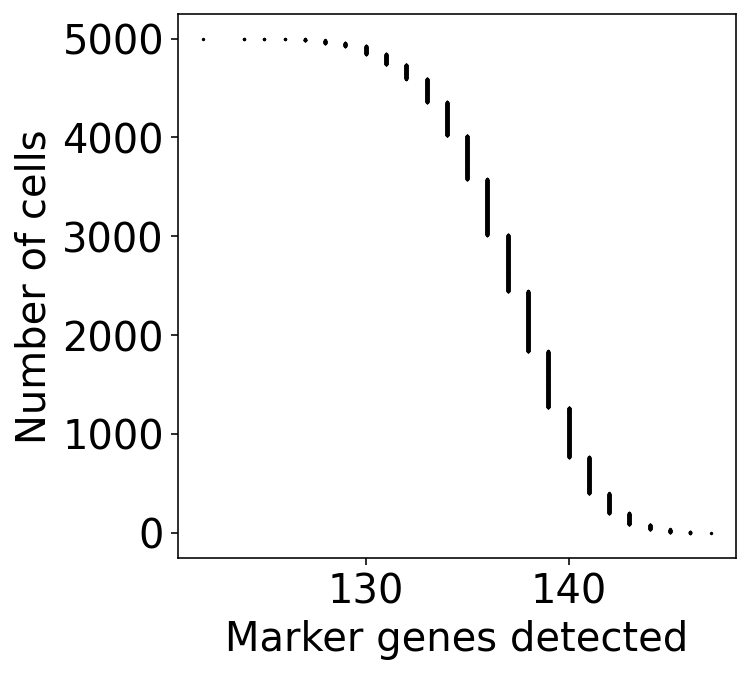

In [29]:
fig, ax = plt.subplots(figsize=(5,5))

x = np.sort(nd((X>0).sum(1)))[::-1]
y = np.arange(X.shape[0])

ax.scatter(x,y, color="k", s=0.5)

ax.set(**{
    "xlabel": "Marker genes detected",
    "ylabel": "Number of cells"
})

fig.show()

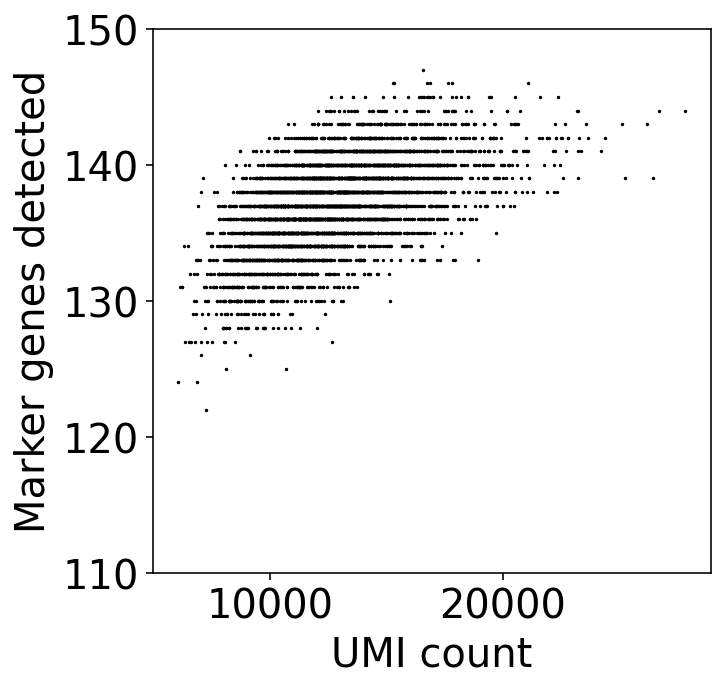

In [30]:
fig, ax = plt.subplots(figsize=(5,5))

x = nd(G.sum(1))
y = nd((X>0).sum(1))

ax.scatter(x,y, color="k", s=0.5)

ax.set(**{
    "xlabel": "UMI count",
    "ylabel": "Marker genes detected",
    "ylim": (110,150)
})

fig.show()

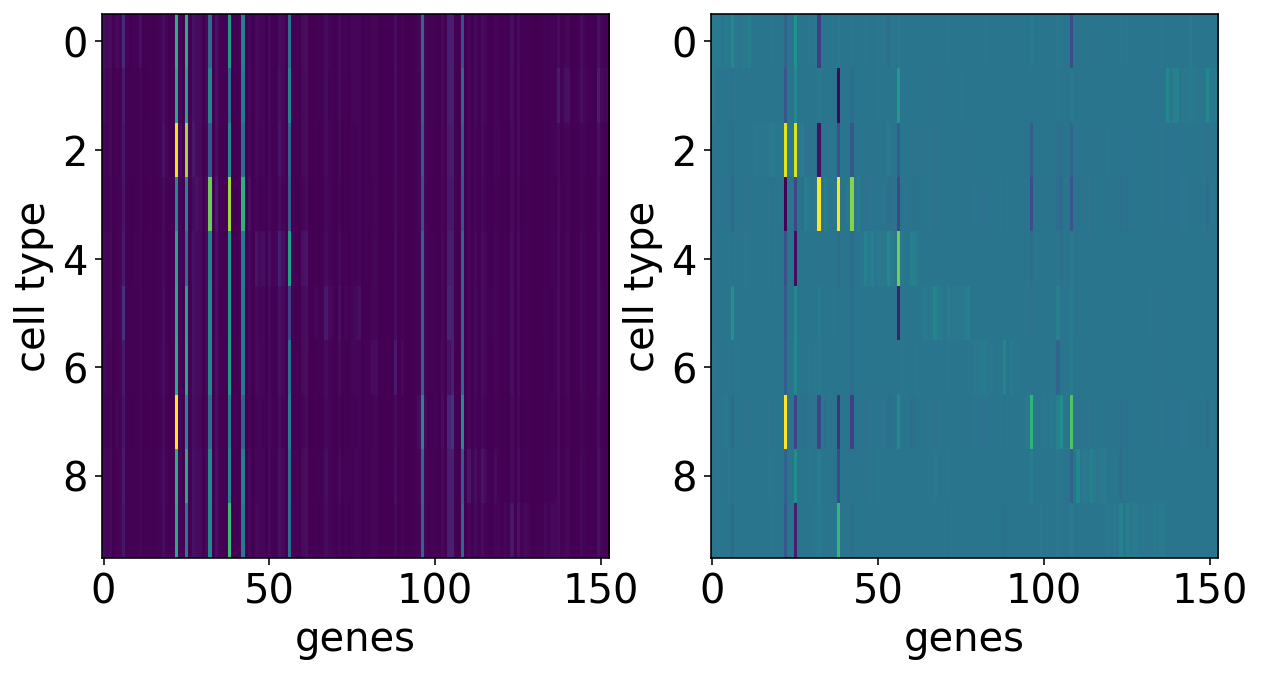

In [31]:
fig, axs = plt.subplots(figsize=(10,5), ncols=2)

ax = axs[0]
ax.imshow(gt_means, aspect="auto")
ax.set(**{
    "xlabel": "genes",
    "ylabel": "cell type"
})
ax = axs[1]
ax.imshow(gt_means_norm, aspect="auto")
ax.set(**{
    "xlabel": "genes",
    "ylabel": "cell type"
})
fig.show()

In [32]:
gmm_params = {
            "n_components": n_clusters,
            "means_init": None, # added
            "weights_init": None, # added
            "precisions_init": None, # added
            "random_state": 0,
            "reg_covar": 1e-8,
            "verbose": 2,
            "n_init": 1,
            "max_iter": 100,
            "tol": 1e-3,
            "init_params": "random"
  }

# init_types = ["kmeans", "manual", "random"]
# models = ["standard", "mine"]  

In [33]:
def prec_good(precision):
  print("Sym, Pos: ", np.allclose(precision, precision.T), ", ", np.all(linalg.eigvalsh(precision) > 0.0))

# Init: Standard KMeans, GMM: Standard

In [34]:
params = {**gmm_params, "init_params":"kmeans"}
print(json.dumps(params, indent=4))

gmm = StandardGaussianMixture(**params)

labels = gmm.fit_predict(X)
means = gmm.means_
print("Rand score: ", rand_score(z, labels))

{
    "n_components": 10,
    "means_init": null,
    "weights_init": null,
    "precisions_init": null,
    "random_state": 0,
    "reg_covar": 1e-08,
    "verbose": 2,
    "n_init": 1,
    "max_iter": 100,
    "tol": 0.001,
    "init_params": "kmeans"
}
Initialization 0
  Iteration 10	 time lapse 5.70799s	 ll change 0.02766
Initialization converged: True	 time lapse 10.44894s	 ll -807.83862
Rand score:  0.9299890378075615


In [68]:
params = {**gmm_params, "init_params":"kmeans"}
print(json.dumps(params, indent=4))

gmm = StandardGaussianMixture(**params)

labels = gmm.fit_predict(X_norm)
means = gmm.means_
print("Rand score: ", rand_score(z, labels))

{
    "n_components": 10,
    "means_init": null,
    "weights_init": null,
    "precisions_init": null,
    "random_state": 0,
    "reg_covar": 1e-08,
    "verbose": 2,
    "n_init": 1,
    "max_iter": 100,
    "tol": 0.001,
    "init_params": "kmeans"
}
Initialization 0
  Iteration 10	 time lapse 5.65013s	 ll change 0.02738
Initialization converged: True	 time lapse 10.38200s	 ll -807.83858
Rand score:  0.9299890378075615


In [35]:
dist = cdist(gt_means_norm, means)#, metric="cityblock")
print(np.argmin(dist, axis=0))

[7 3 2 7 2 2 2 2 3 7]


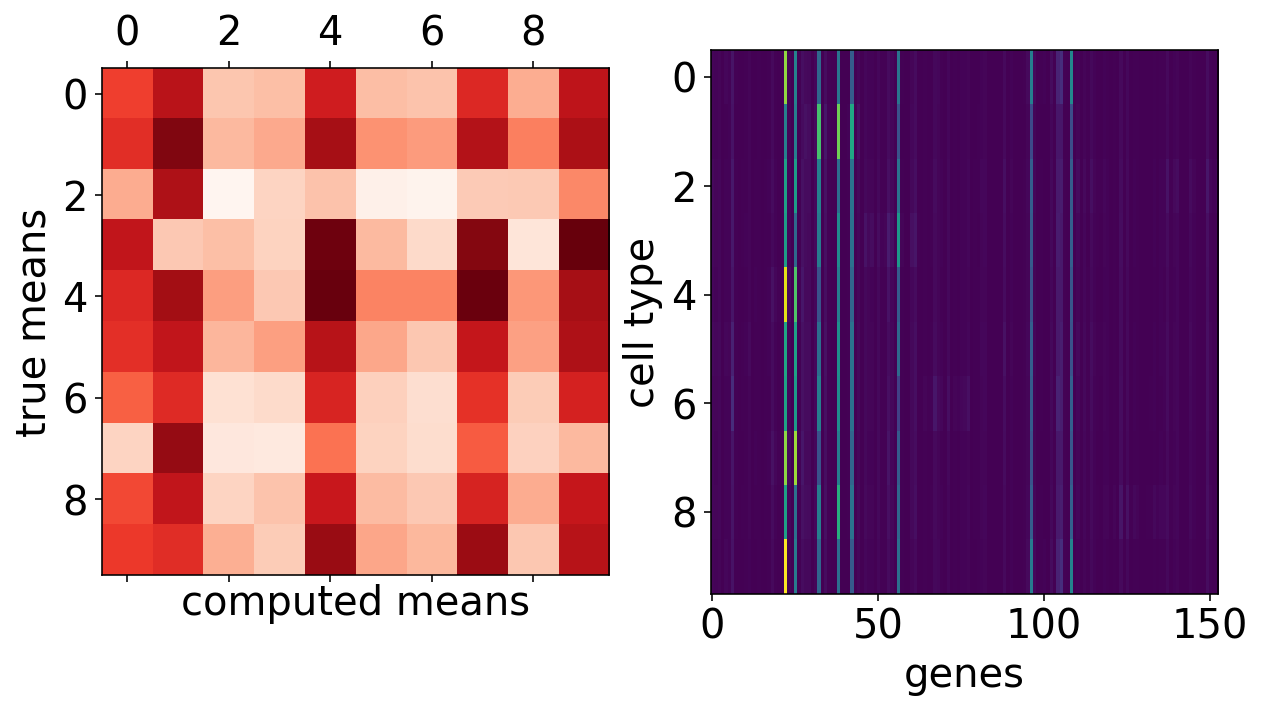

In [36]:
fig, axs = plt.subplots(figsize=(10,5), ncols=2)

ax = axs[0]

ax.matshow(dist, cmap='Reds')
ax.set(**{
    "xlabel":"computed means",
    "ylabel": "true means"
    })

ax = axs[1]
ax.imshow(means, aspect="auto")
ax.set(**{
    "xlabel": "genes",
    "ylabel": "cell type"
})
fig.show()

# Init: Standard KMeans, GMM: Improved

In [37]:
params = {**gmm_params, "init_params": "kmeans"}
print(json.dumps(params, indent=4))

gmm = ImprovedGaussianMixture(**params)

labels = gmm.fit_predict(X, B=markers_ec)
means = gmm.means_

print("Rand score: ", rand_score(z, labels))

{
    "n_components": 10,
    "means_init": null,
    "weights_init": null,
    "precisions_init": null,
    "random_state": 0,
    "reg_covar": 1e-08,
    "verbose": 2,
    "n_init": 1,
    "max_iter": 100,
    "tol": 0.001,
    "init_params": "kmeans"
}
Initialization 0
  Iteration 10	 time lapse 5.73448s	 ll change 0.03312
Initialization converged: True	 time lapse 10.43959s	 ll -826.39428
Rand score:  0.9299938387677535


In [38]:
dist = cdist(gt_means_norm, means)#, metric="cityblock")
print(np.argmin(dist, axis=0))

[6 2 3 4 6 6 7 6 6 6]


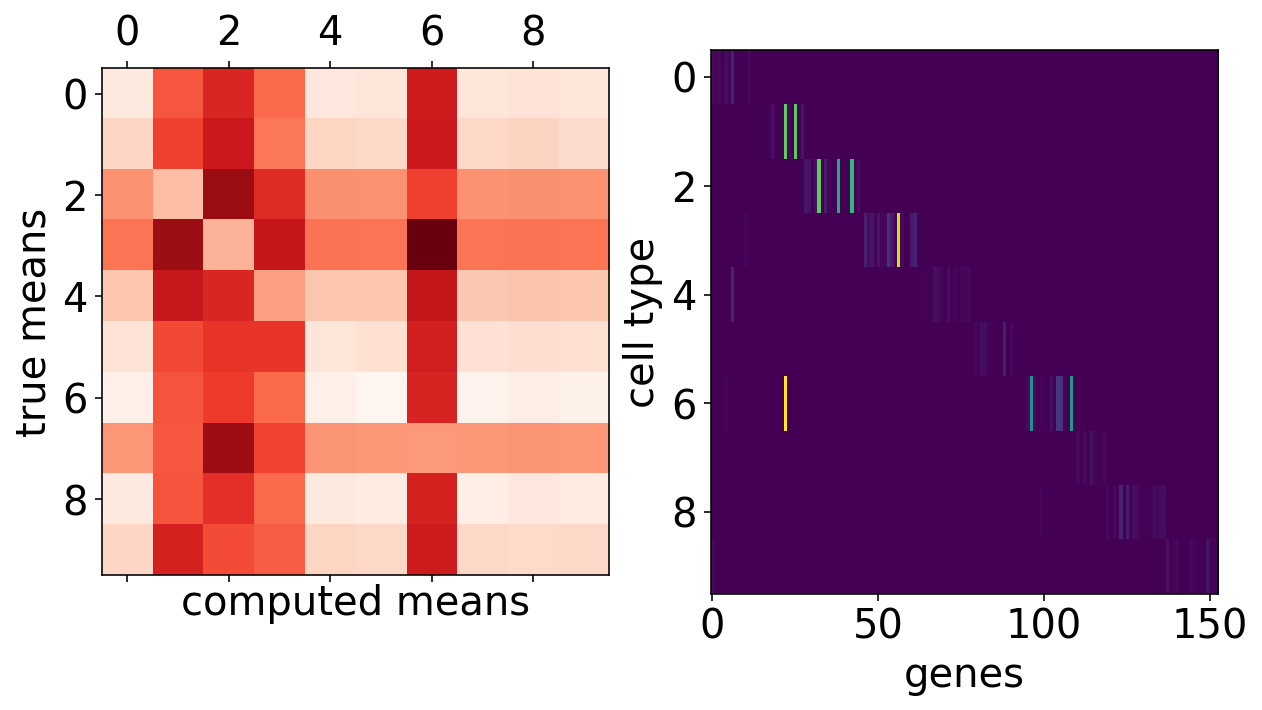

In [39]:
fig, axs = plt.subplots(figsize=(10,5), ncols=2)

ax = axs[0]

ax.matshow(dist, cmap='Reds')
ax.set(**{
    "xlabel":"computed means",
    "ylabel": "true means"
    })

ax = axs[1]
ax.imshow(means, aspect="auto")
ax.set(**{
    "xlabel": "genes",
    "ylabel": "cell type"
})
fig.show()

# Init: Manual KMeans, GMM: Standard

In [40]:
def make_precisions(covariances):
  n_components, n_features, _ = covariances.shape
  precisions = np.empty((n_components, n_features, n_features))
  for k, covariance in enumerate(covariances):
      # cov_chol = linalg.cholesky(covariance, lower=True)
      # precisions[k] = linalg.solve(cov_chol,
      #                              np.eye(n_features),
      #                              lower=True).T
      precisions[k] = linalg.inv(covariance)
  return precisions

In [41]:
# https://stackoverflow.com/a/63801808/13731947

n_samples, n_features = X.shape

## own kmeans initialization

km = KMeans(n_clusters=n_clusters, n_init=1, random_state=0)
km.fit(X)
km_labels = km.labels_
centroids = km.cluster_centers_

# calculate the weights
resp = np.zeros((n_samples, n_clusters))
resp[np.arange(n_samples), km_labels] = 1

# run gmm initialization of paramaters with given responsibilities and centroids

weights_init, means_init, covariances = est_gaus_params(
    X, resp, reg_covar=gmm_params["reg_covar"], covariance_type="full")
weights_init /= n_samples

# set the precision
# the _compute_precision_cholesky uses a lower trangular solver that makes the matrices not symmetric
precisions_init = make_precisions(covariances)

print([np.allclose(i, i.T) for i in precisions_init])
print([np.all(linalg.eigvalsh(i) > 0.0) for i in precisions_init])

[True, True, True, True, True, True, True, True, True, True]
[True, True, True, True, True, True, True, True, True, True]


In [42]:
params = {**gmm_params, 
          "means_init": means_init,
          "weights_init": weights_init, 
          "precisions_init": precisions_init
          }
print(json.dumps(params, indent=4, default=str))

gmm = StandardGaussianMixture(**params)

labels = gmm.fit_predict(X)
means = gmm.means_
print("Rand score: ", rand_score(z, labels))

{
    "n_components": 10,
    "means_init": "[[297.60464174 188.92268109 310.83471646 ... 199.23614238  99.50896783\n  137.78330033]\n [287.08242963 186.40781007 306.47682947 ... 201.52386087 104.13833135\n  131.54760629]\n [497.64847802 242.15208157 374.65232255 ... 342.0727616  202.74359738\n  334.07667651]\n ...\n [339.69763422 206.19577178 371.76130699 ... 234.80016093 112.47850492\n  152.43481098]\n [382.1125234  242.0287198  384.30159605 ... 262.13603917 130.63701896\n  177.8753184 ]\n [281.07483818 179.29349978 297.27532752 ... 193.57602366  99.56221326\n  126.80801332]]",
    "weights_init": "[0.0468 0.1054 0.1848 0.0976 0.0534 0.191  0.1096 0.0464 0.118  0.047 ]",
    "precisions_init": "[[[658305.10624825 658305.10559122 658305.10560892 ... 658305.1056973\n   658305.10546731 658305.10557817]\n  [658305.10559136 658305.10629797 658305.10554218 ... 658305.10562865\n   658305.10562364 658305.10575642]\n  [658305.10560896 658305.10554209 658305.10588206 ... 658305.10567627\n   65

In [43]:
dist = cdist(gt_means_norm, means)#, metric="cityblock")
print(np.argmin(dist, axis=0))

[7 3 2 7 2 2 2 2 3 7]


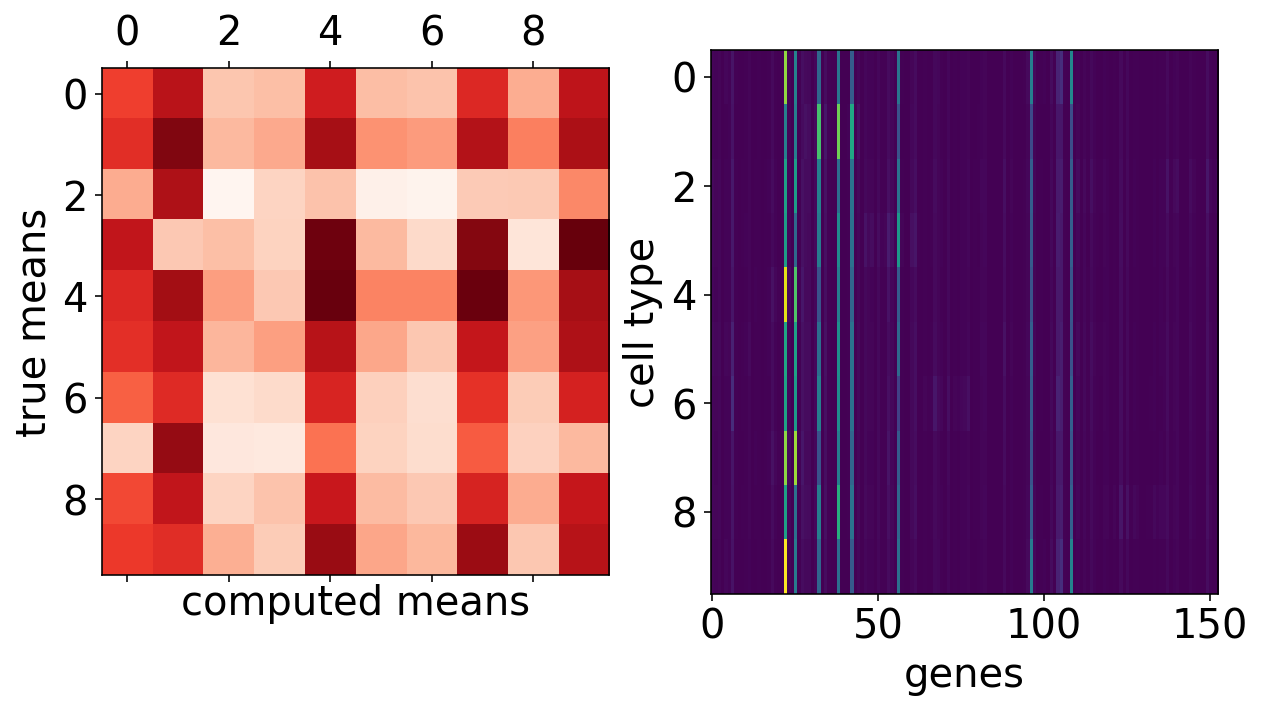

In [44]:
fig, axs = plt.subplots(figsize=(10,5), ncols=2)

ax = axs[0]

ax.matshow(dist, cmap='Reds')
ax.set(**{
    "xlabel":"computed means",
    "ylabel": "true means"
    })

ax = axs[1]
ax.imshow(means, aspect="auto")
ax.set(**{
    "xlabel": "genes",
    "ylabel": "cell type"
})
fig.show()

# Init: Manual KMeans, GMM: Improved

In [45]:
params = {**gmm_params, 
          "means_init": means_init,
          "weights_init": weights_init, 
          "precisions_init": precisions_init
          }
print(json.dumps(params, indent=4, default=str))

gmm = ImprovedGaussianMixture(**params)

labels = gmm.fit_predict(X, B=markers_ec)
means = gmm.means_
print("Rand score: ", rand_score(z, labels))

{
    "n_components": 10,
    "means_init": "[[297.60464174 188.92268109 310.83471646 ... 199.23614238  99.50896783\n  137.78330033]\n [287.08242963 186.40781007 306.47682947 ... 201.52386087 104.13833135\n  131.54760629]\n [497.64847802 242.15208157 374.65232255 ... 342.0727616  202.74359738\n  334.07667651]\n ...\n [339.69763422 206.19577178 371.76130699 ... 234.80016093 112.47850492\n  152.43481098]\n [382.1125234  242.0287198  384.30159605 ... 262.13603917 130.63701896\n  177.8753184 ]\n [281.07483818 179.29349978 297.27532752 ... 193.57602366  99.56221326\n  126.80801332]]",
    "weights_init": "[0.0468 0.1054 0.1848 0.0976 0.0534 0.191  0.1096 0.0464 0.118  0.047 ]",
    "precisions_init": "[[[658305.10624825 658305.10559122 658305.10560892 ... 658305.1056973\n   658305.10546731 658305.10557817]\n  [658305.10559136 658305.10629797 658305.10554218 ... 658305.10562865\n   658305.10562364 658305.10575642]\n  [658305.10560896 658305.10554209 658305.10588206 ... 658305.10567627\n   65

In [46]:
dist = cdist(gt_means_norm, means)#, metric="cityblock")
print(np.argmin(dist, axis=0))

[6 2 3 4 6 6 7 6 6 6]


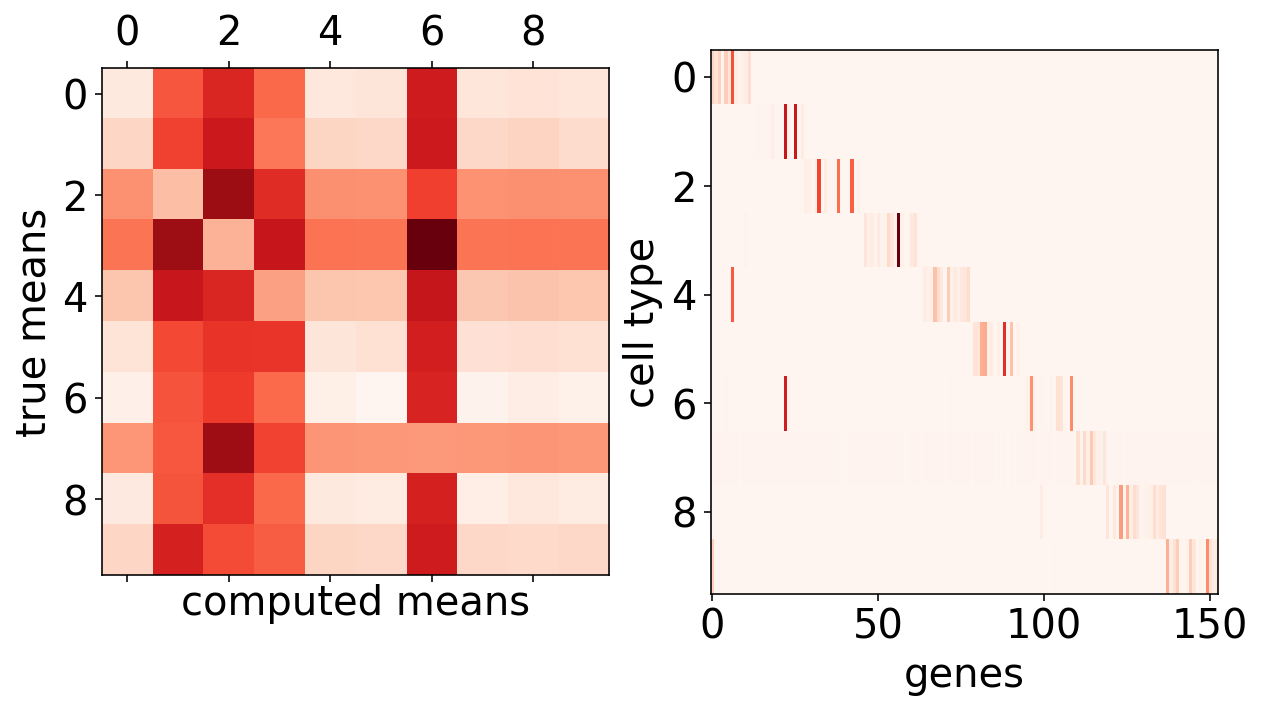

In [47]:
fig, axs = plt.subplots(figsize=(10,5), ncols=2)

ax = axs[0]

ax.matshow(dist, cmap='Reds')
ax.set(**{
    "xlabel":"computed means",
    "ylabel": "true means"
    })

ax = axs[1]
ax.imshow(normalize(means, 'l1'), aspect="auto", cmap="Reds")
ax.set(**{
    "xlabel": "genes",
    "ylabel": "cell type"
})
fig.show()

# Init: Manual Self GMM: Standard

In [48]:
centroids = np.ones((n_clusters, n_features))*1e-5

for i in list(markers_ec.keys()):
  for j in markers_ec[i]:
    centroids[i][j] = X_max[j]
 
tree = KDTree(centroids)
nearest_dist, nearest_ind = tree.query(X_norm, k=1)

# assign cells to clusters
p = 0.95
resp = np.ones((n_samples, n_clusters))*(1-p)/(n_clusters-1)
resp[np.arange(n_samples), nd(nearest_ind)] = p

# M step from GMM code
weights_init, means_init, covariances = est_gaus_params(
    X_norm, resp, reg_covar=gmm_params["reg_covar"], covariance_type="full")
weights_init /= n_samples

# set the precision
precisions_init = make_precisions(covariances)
print([np.allclose(i, i.T) for i in precisions_init])
print([np.all(linalg.eigvalsh(i) > 0.0) for i in precisions_init])

# actually used params
nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
means_init = np.dot(resp.T, X_norm) / nk[:, np.newaxis]
uniform_weights = np.array([1./n_clusters]*n_clusters)
identity_precisions = np.repeat(np.array([np.eye(X.shape[1])]), n_clusters, 0)

[True, True, True, True, True, True, True, True, True, True]
[True, True, True, True, True, True, True, True, True, True]


In [49]:
params = {**gmm_params, 
          "means_init": means_init,
          "weights_init": weights_init, 
          "precisions_init": precisions_init
          }
print(json.dumps(params, indent=4, default=str))

gmm = StandardGaussianMixture(**params)

labels = gmm.fit_predict(X_norm)
means = gmm.means_
print("Rand score: ", rand_score(z, labels))

{
    "n_components": 10,
    "means_init": "[[ 238.72510121  190.48060822  244.45532808 ...   11.0036206\n    -8.29141679  -17.00780322]\n [ -72.33905323  -36.28344979   -9.82599986 ...  -30.27732606\n   -27.8005842   -42.70022228]\n [-103.7006304   -62.63216218  -74.38796069 ...  -48.45137566\n   -33.281143    -56.4607159 ]\n ...\n [ -24.90122262    2.59877489   25.36614654 ...    6.56094708\n    -1.3247786   -21.47865117]\n [ -29.40109476   -9.27878332   17.29316195 ...   11.0301959\n    -5.98094823  -17.58646126]\n [ 194.60068922  -12.32323617    2.82494799 ...  164.94931902\n   125.20291816  280.92910932]]",
    "weights_init": "[0.06864444 0.03785556 0.03728889 0.05183333 0.083      0.42205556\n 0.02803333 0.09773333 0.10604444 0.06751111]",
    "precisions_init": "[[[654523.87607084 654523.87598712 654523.87596683 ... 654523.87598212\n   654523.87597598 654523.87598663]\n  [654523.87598708 654523.87607853 654523.87595811 ... 654523.87598916\n   654523.87597793 654523.87598704]\n

# Init: Means, uniform weights, identify precisions, GMM: Standard

In [50]:
params = {**gmm_params, 
          "means_init": means_init, # centroids,
          "weights_init": uniform_weights,
          "precisions_init": identity_precisions
          }
print(json.dumps(params, indent=4, default=str))

gmm = StandardGaussianMixture(**params)

labels = gmm.fit_predict(X_norm)
means = gmm.means_
print("Rand score: ", rand_score(z, labels))

{
    "n_components": 10,
    "means_init": "[[ 238.72510121  190.48060822  244.45532808 ...   11.0036206\n    -8.29141679  -17.00780322]\n [ -72.33905323  -36.28344979   -9.82599986 ...  -30.27732606\n   -27.8005842   -42.70022228]\n [-103.7006304   -62.63216218  -74.38796069 ...  -48.45137566\n   -33.281143    -56.4607159 ]\n ...\n [ -24.90122262    2.59877489   25.36614654 ...    6.56094708\n    -1.3247786   -21.47865117]\n [ -29.40109476   -9.27878332   17.29316195 ...   11.0301959\n    -5.98094823  -17.58646126]\n [ 194.60068922  -12.32323617    2.82494799 ...  164.94931902\n   125.20291816  280.92910932]]",
    "weights_init": "[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]",
    "precisions_init": "[[[1. 0. 0. ... 0. 0. 0.]\n  [0. 1. 0. ... 0. 0. 0.]\n  [0. 0. 1. ... 0. 0. 0.]\n  ...\n  [0. 0. 0. ... 1. 0. 0.]\n  [0. 0. 0. ... 0. 1. 0.]\n  [0. 0. 0. ... 0. 0. 1.]]\n\n [[1. 0. 0. ... 0. 0. 0.]\n  [0. 1. 0. ... 0. 0. 0.]\n  [0. 0. 1. ... 0. 0. 0.]\n  ...\n  [0. 0. 0. ... 1. 0. 0.]\n  [

In [51]:
dist = cdist(gt_means_norm, means)#, metric="cityblock")
print(np.argmin(dist, axis=0))

[0 2 3 4 5 6 7 8 9 1]


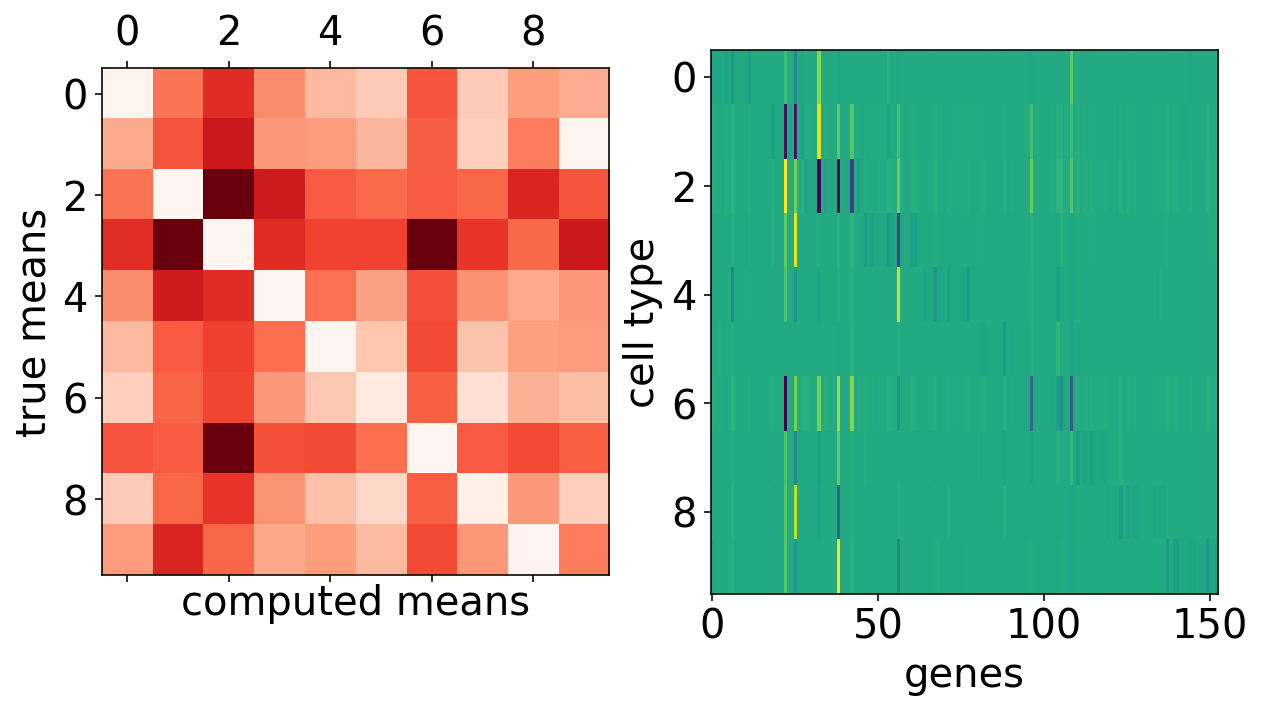

In [52]:
fig, axs = plt.subplots(figsize=(10,5), ncols=2)

ax = axs[0]

ax.matshow(dist, cmap='Reds')
ax.set(**{
    "xlabel":"computed means",
    "ylabel": "true means"
    })

ax = axs[1]
ax.imshow(means, aspect="auto", cmap="viridis_r")
ax.set(**{
    "xlabel": "genes",
    "ylabel": "cell type"
})
fig.show()

In [53]:
pr = gmm.predict_proba(X_norm)
pr_plot = np.zeros((n_samples, n_clusters))
n = 0
for i in np.unique(labels):
  inds = np.where(labels == i)[0]
  pr_plot[n:n+len(inds)] = pr[inds]
  n += len(inds)

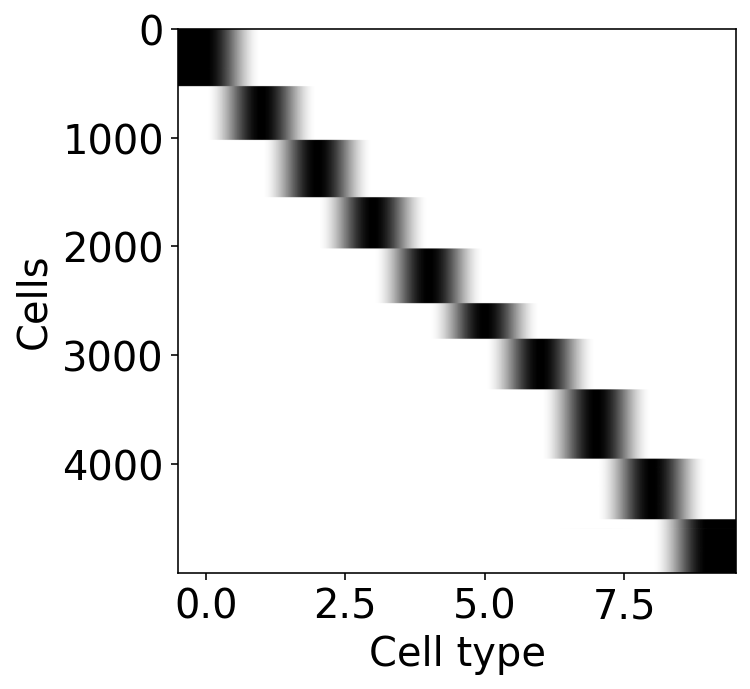

In [54]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(pr_plot, aspect="auto",cmap="binary")
ax.set(**{
    "xlabel": "Cell type",
    "ylabel": "Cells"
})
fig.show()

# Init: Means, uniform weights, identify precisions , GMM: Improved

In [55]:
params = {**gmm_params, 
          "means_init": means_init, # centroids,
          "weights_init": uniform_weights, 
          "precisions_init": identity_precisions
          }
print(json.dumps(params, indent=4, default=str))

gmm = ImprovedGaussianMixture(**params)

labels = gmm.fit_predict(X_norm, B=markers_ec)
means = gmm.means_
print("Rand score: ", rand_score(z, labels))

{
    "n_components": 10,
    "means_init": "[[ 238.72510121  190.48060822  244.45532808 ...   11.0036206\n    -8.29141679  -17.00780322]\n [ -72.33905323  -36.28344979   -9.82599986 ...  -30.27732606\n   -27.8005842   -42.70022228]\n [-103.7006304   -62.63216218  -74.38796069 ...  -48.45137566\n   -33.281143    -56.4607159 ]\n ...\n [ -24.90122262    2.59877489   25.36614654 ...    6.56094708\n    -1.3247786   -21.47865117]\n [ -29.40109476   -9.27878332   17.29316195 ...   11.0301959\n    -5.98094823  -17.58646126]\n [ 194.60068922  -12.32323617    2.82494799 ...  164.94931902\n   125.20291816  280.92910932]]",
    "weights_init": "[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]",
    "precisions_init": "[[[1. 0. 0. ... 0. 0. 0.]\n  [0. 1. 0. ... 0. 0. 0.]\n  [0. 0. 1. ... 0. 0. 0.]\n  ...\n  [0. 0. 0. ... 1. 0. 0.]\n  [0. 0. 0. ... 0. 1. 0.]\n  [0. 0. 0. ... 0. 0. 1.]]\n\n [[1. 0. 0. ... 0. 0. 0.]\n  [0. 1. 0. ... 0. 0. 0.]\n  [0. 0. 1. ... 0. 0. 0.]\n  ...\n  [0. 0. 0. ... 1. 0. 0.]\n  [

In [56]:
# dist = np.zeros((n_clusters, n_clusters))
# for idx in np.arange(B.shape[0]):
#   for jdx in np.arange(B.shape[0]):
#     mask = B[idx].astype(bool)
#     a,b = gt_means_norm[idx][mask].reshape(1,-1), means[jdx][mask].reshape(1,-1)
#     dist[idx, jdx] = euclidean_distances(a,b)

In [57]:
dist = cdist(gt_means_norm, means)#, metric="cityblock")
print(np.argmin(dist, axis=0))

[0 2 3 4 5 6 7 8 9 1]


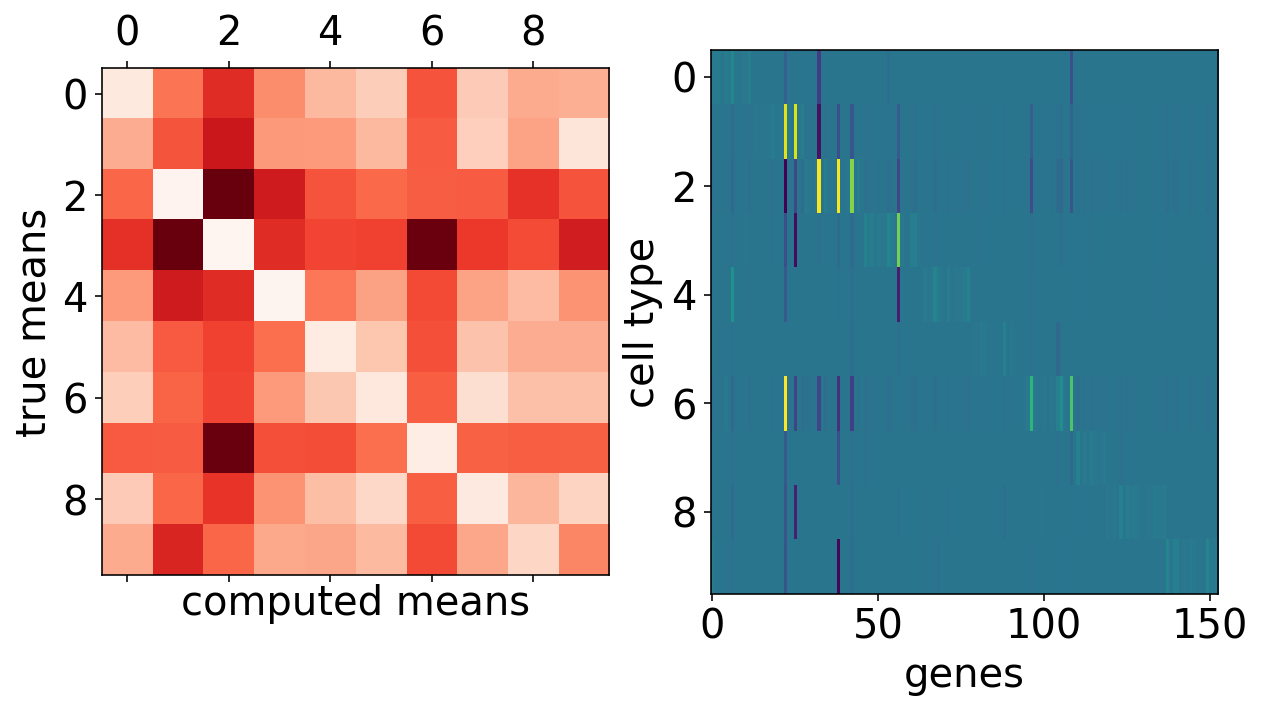

In [58]:
fig, axs = plt.subplots(figsize=(10,5), ncols=2)

ax = axs[0]
ax.matshow(dist, cmap='Reds')
ax.set(**{
    "xlabel":"computed means",
    "ylabel": "true means"
    })

ax = axs[1]
ax.imshow(means, aspect="auto")
ax.set(**{
    "xlabel": "genes",
    "ylabel": "cell type"
})
fig.show()

In [59]:
gt_means_norm[0].astype(int)

array([  255,   204,   249,    13,   257,   141,   858,    66,     8,
          79,    89,   412,     1,     1,     1,     2,     2,     6,
          21,    -4,    -5,     3,  -639,   -80,     0,  1231,     5,
          40,   -83,    30,     0,    17, -2047,     1,     8,     6,
          -1,     1,   137,     0,     0,     1,    16,     0,   -11,
          -1,    13,     5,    -8,    -8,    29,     1,    -2,  -266,
          13,     4,   146,    -4,     0,    -1,     9,    12,     3,
           0,    -9,     2,    -6,   -38,     6,    -2,     0,    21,
           0,     3,    -1,     2,    -5,   -27,     0,     4,     7,
           1,    18,     1,     0,     0,     0,     0,     2,     1,
          -3,     0,     0,    -5,     7,     3,   132,     0,     4,
          -5,    -1,     0,     9,     0,    67,    14,     3,     0,
       -1493,     0,   -44,     3,     2,    12,    -7,    -2,     0,
           0,    -5,    -4,    -1,    -3,     0,    22,    -1,    13,
           0,   -19,

In [60]:
means[0].astype(int)

array([  226,   184,   218,    12,   231,   128,   775,    61,     7,
          71,    80,   370,     0,     3,     1,     1,     2,     3,
           3,    -5,    -5,     2,  -714,   -70,     0,     3,     3,
           3,   -72,     3,     0,     3, -2034,     1,     3,     3,
          -1,     2,     3,     0,     0,     0,     2,    -1,    -9,
          -1,     3,     3,   -11,    -7,     3,     0,    -3,  -246,
           3,     3,     3,    -3,     0,     0,     3,     3,     2,
           0,    -9,     2,    -7,   -31,     3,    -1,     0,     3,
           0,     3,    -1,     1,    -4,   -27,     0,     3,     3,
           3,     3,     3,     1,     0,     2,     0,     3,     1,
           3,     0,     1,    -5,     3,     0,     3,     2,     3,
          -4,    -1,     0,     3,     0,     3,     3,     2,     0,
       -1408,     0,   -26,     3,     3,     3,     0,     0,     1,
           1,    -2,    -5,    -1,    -3,     0,     3,    -1,     3,
          -1,   -17,

In [61]:
pr = gmm.predict_proba(X_norm)
pr_plot = np.zeros((n_samples, n_clusters))
n = 0
for i in np.unique(labels):
  inds = np.where(labels == i)[0]
  pr_plot[n:n+len(inds)] = pr[inds]
  n += len(inds)

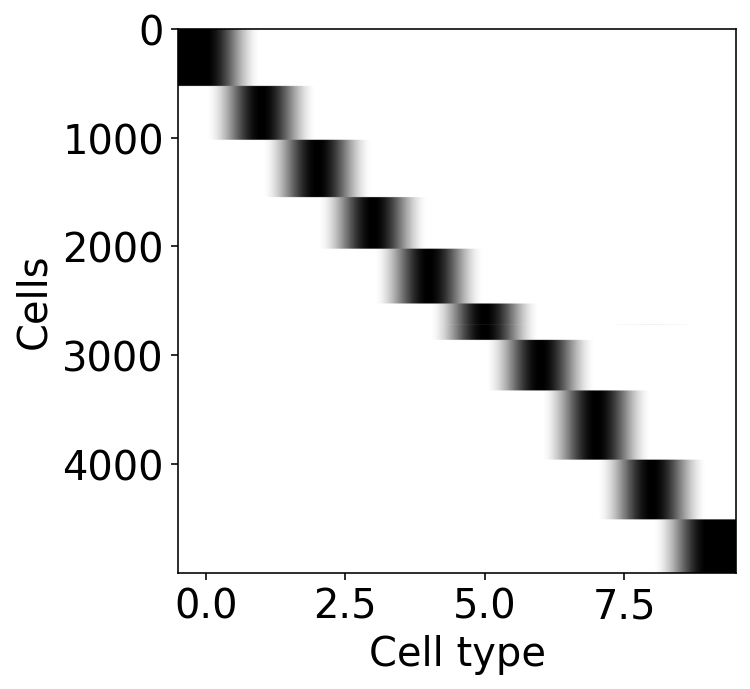

In [62]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(pr_plot, aspect="auto",cmap="binary")
ax.set(**{
    "xlabel": "Cell type",
    "ylabel": "Cells"
})
fig.show()

# Sampled

In [83]:
n_samples_s = int(n_samples*0.01)
sind = np.random.choice(n_samples, size=n_samples_s, replace=False)

In [84]:
X_norm_s = X_norm[sind]
z_s = z[sind]

In [85]:
centroids = np.ones((n_clusters, n_features))*1e-5

for i in list(markers_ec.keys()):
  for j in markers_ec[i]:
    centroids[i][j] = X_max[j]
 
tree = KDTree(centroids)
nearest_dist, nearest_ind = tree.query(X_norm_s, k=1)

# assign cells to clusters
p = 0.95
resp = np.ones((n_samples_s, n_clusters))*(1-p)/(n_clusters-1)
resp[np.arange(n_samples_s), nd(nearest_ind)] = p

# M step from GMM code
weights_init, means_init, covariances = est_gaus_params(
    X_norm_s, resp, reg_covar=gmm_params["reg_covar"], covariance_type="full")
weights_init /= n_samples_s

# set the precision
precisions_init = make_precisions(covariances)
print([np.allclose(i, i.T) for i in precisions_init])
print([np.all(linalg.eigvalsh(i) > 0.0) for i in precisions_init])

# actually used params
nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
means_init = np.dot(resp.T, X_norm_s) / nk[:, np.newaxis]
uniform_weights = np.array([1./n_clusters]*n_clusters)
identity_precisions = np.repeat(np.array([np.eye(X.shape[1])]), n_clusters, 0)

[False, False, False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False, False, False]


In [86]:
params = {**gmm_params, 
          "means_init": means_init, # centroids,
          "weights_init": uniform_weights, 
          "precisions_init": identity_precisions
          }
print(json.dumps(params, indent=4, default=str))

gmm = ImprovedGaussianMixture(**params)

labels = gmm.fit_predict(X_norm_s, B=markers_ec)
means = gmm.means_
print("Rand score: ", rand_score(z_s, labels))

{
    "n_components": 10,
    "means_init": "[[ 359.7993055   224.58486009  220.52320538 ...  -46.60148585\n   -12.73625429    0.89924581]\n [-166.10998485  -41.74983386   48.21343947 ...  -77.65438683\n    -5.56717304  -62.33170858]\n [ -21.7931328   -75.65774746  -52.06293704 ...    9.144561\n   -62.32567148    7.85726169]\n ...\n [  -2.81269621   40.90278829  -54.56718227 ...  -14.60625082\n    55.0669873   -29.07224579]\n [ -23.8187792   -19.50735902   15.61310161 ...   63.63250666\n   -69.55739143  -28.64804898]\n [ 144.10617323   16.56088016  -58.10118707 ...  196.91984813\n   110.0908707   291.64844233]]",
    "weights_init": "[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]",
    "precisions_init": "[[[1. 0. 0. ... 0. 0. 0.]\n  [0. 1. 0. ... 0. 0. 0.]\n  [0. 0. 1. ... 0. 0. 0.]\n  ...\n  [0. 0. 0. ... 1. 0. 0.]\n  [0. 0. 0. ... 0. 1. 0.]\n  [0. 0. 0. ... 0. 0. 1.]]\n\n [[1. 0. 0. ... 0. 0. 0.]\n  [0. 1. 0. ... 0. 0. 0.]\n  [0. 0. 1. ... 0. 0. 0.]\n  ...\n  [0. 0. 0. ... 1. 0. 0.]\n  [

In [87]:
X.shape

(5000, 153)

# Testing the means adjustment

In [63]:
means = np.random.randint(-100,100,size=(n_clusters, n_features))

for bidx, b in enumerate(B):
  m = b.astype(bool)
  means[bidx][m] = np.random.randint(10,100, size=m.sum())

before = means[0]
print(before)

[ 12  70  46  11  14  14  57  83  95  11  87  93 -90  37 -86 -27 -25 -49
  41  23 -47  69  92  73 -77 -37 -21 -39  -3 -10 -17  86 -63  31 -55 -69
 -15  57  23 -76 -18  39  84  56 -68 -72 -91   4  72 -83 -45 -20 -82  39
 -93 -42 -70 -38  83  56 -93 -81  -6  91  72 -96 -16   9  70  88 -33  89
 -84 -25  34 -66  16  56 -60  75 -26  18  29  72  64  11  74 -97  79  92
 -74 -31 -99  71 -59   3 -28   7  78 -22  23   4 -40  46 -63 -17 -29  88
  72  29 -24  74 -68  10  84 -27 -34 -87  94   9 -77  12   0 -28  96 -91
 -87  95 -10  -1  93  41  82  13  51 -86  73  19 -66  48  63  57 -79 -88
 -51 -57  -6  24  84  18 -48   3  37]


In [64]:
ct_mins = [means[i][B[i].astype(bool)].min() for i in range(means.shape[0])]
marker_gene_indices = [set(B[i]) for i in range(means.shape[0])]
# modify based on the min/f
f = 2.
for idx, i in enumerate(means):
    ct_min = ct_mins[idx]
    betas = means[idx]
    for jdx, b in enumerate(betas):
        if jdx not in marker_gene_indices[idx]:
            new = min(b, ct_min / f)
            means[idx][jdx] = new

In [65]:
print(np.array(list(zip(before, means[0]))))

[[ 12  12]
 [ 70  70]
 [  5   5]
 [  5   5]
 [  5   5]
 [  5   5]
 [  5   5]
 [  5   5]
 [  5   5]
 [  5   5]
 [  5   5]
 [  5   5]
 [-90 -90]
 [  5   5]
 [-86 -86]
 [-27 -27]
 [-25 -25]
 [-49 -49]
 [  5   5]
 [  5   5]
 [-47 -47]
 [  5   5]
 [  5   5]
 [  5   5]
 [-77 -77]
 [-37 -37]
 [-21 -21]
 [-39 -39]
 [ -3  -3]
 [-10 -10]
 [-17 -17]
 [  5   5]
 [-63 -63]
 [  5   5]
 [-55 -55]
 [-69 -69]
 [-15 -15]
 [  5   5]
 [  5   5]
 [-76 -76]
 [-18 -18]
 [  5   5]
 [  5   5]
 [  5   5]
 [-68 -68]
 [-72 -72]
 [-91 -91]
 [  4   4]
 [  5   5]
 [-83 -83]
 [-45 -45]
 [-20 -20]
 [-82 -82]
 [  5   5]
 [-93 -93]
 [-42 -42]
 [-70 -70]
 [-38 -38]
 [  5   5]
 [  5   5]
 [-93 -93]
 [-81 -81]
 [ -6  -6]
 [  5   5]
 [  5   5]
 [-96 -96]
 [-16 -16]
 [  5   5]
 [  5   5]
 [  5   5]
 [-33 -33]
 [  5   5]
 [-84 -84]
 [-25 -25]
 [  5   5]
 [-66 -66]
 [  5   5]
 [  5   5]
 [-60 -60]
 [  5   5]
 [-26 -26]
 [  5   5]
 [  5   5]
 [  5   5]
 [  5   5]
 [  5   5]
 [  5   5]
 [-97 -97]
 [  5   5]
 [  5   5]
 [-74 -74]

problem: adjusting values of the centers of the gaussians (derived from mean centered data) 

# Random stuff

In [66]:
# !rm -rf covariances/ means.txt weights.txt
# !mkdir -p covariances
# fs = [open(f"./covariances/data_{i}.txt", 'w') for i in range(covariances.shape[0])]
# for idx, c in enumerate(covariances):
#     np.savetxt(fs[idx], c)

# with open("means.txt", 'w') as f:
#   np.savetxt(f, centroids)

# with open("weights.txt", 'w') as f:
#   np.savetxt(f, weights)

# !tar -cvf covariances.tar.gz covariances

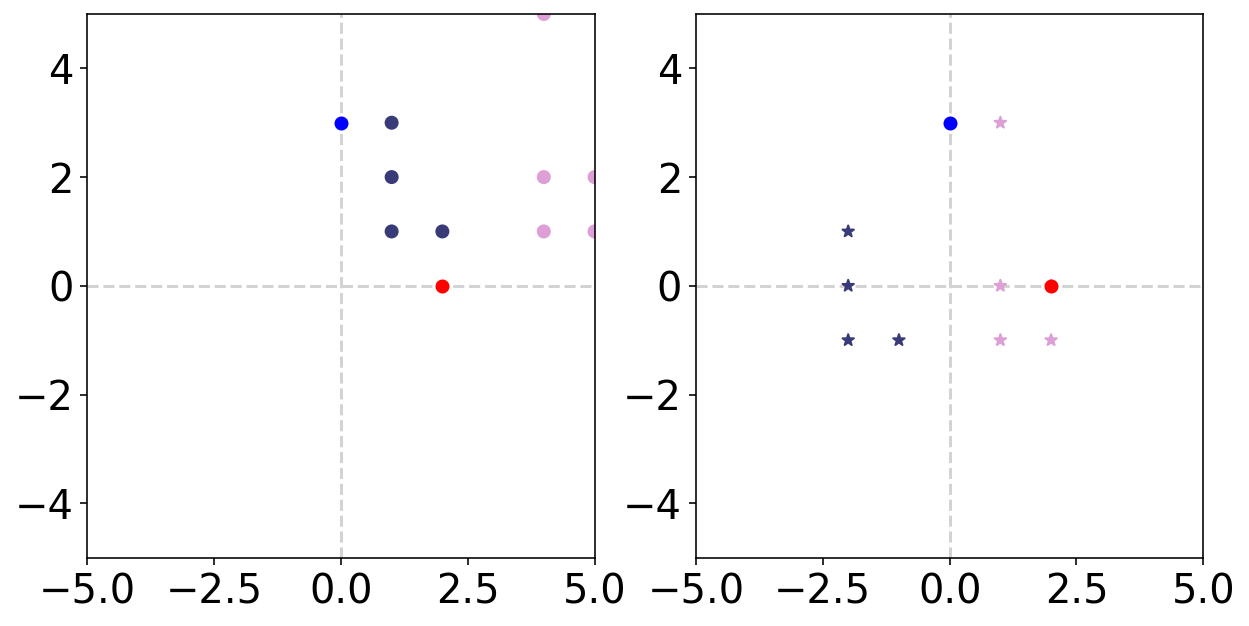

In [67]:
D = np.array(
    [[1,1],
     [1,2],
     [1,3],
     [2,1],
     [4,1],
     [4,2],
     [5,1],
     [5,2],
     [4,5]])
col = [0,0,0,0,1,1,1,1,1]

fig, axs = plt.subplots(figsize=(10,5), ncols=2)

means = D.mean(0)

## standard
ax = axs[0]
D_norm = D - D.mean(0)
D_max = D_norm.max(0)

x = D[:,0]
y = D[:,1]

ax.scatter(x,y, c=col, cmap="tab20b")

ax.axhline(0, linestyle="--", color='lightgray', zorder=-1)
ax.axvline(0, linestyle="--", color='lightgray', zorder=-1)

ax.scatter(D_max[0], 0, color="red")
ax.scatter(0, D_max[1], color="blue")

ax.set(**{
    "xlim": (-5,5),
    "ylim": (-5,5)
})

## subtract mean
ax = axs[1]
x = D_norm[:,0]
y = D_norm[:,1]

ax.scatter(x,y, c=col, cmap="tab20b", marker="*")

ax.axhline(0, linestyle="--", color='lightgray', zorder=-1)
ax.axvline(0, linestyle="--", color='lightgray', zorder=-1)

ax.scatter(D_max[0], 0, color="red")
ax.scatter(0, D_max[1], color="blue")

ax.set(**{
    "xlim": (-5,5),
    "ylim": (-5,5)
})

fig.show()